In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import (accuracy_score, roc_auc_score, recall_score, 
                             precision_score, f1_score, cohen_kappa_score,
                             matthews_corrcoef, confusion_matrix, classification_report)
from scipy.stats import zscore, kruskal, mannwhitneyu
from tqdm import tqdm
import random
import warnings
import xgboost as xgb
import umap

warnings.filterwarnings('ignore')

In [3]:
# Set random seeds for reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print("="*80)
print("MICROBIOME DISEASE CLASSIFICATION")
print("="*80)

MICROBIOME DISEASE CLASSIFICATION


In [4]:
# Download abundance data from GMrepo

import os
import urllib.request

# List of files to download with their URLs
files_to_download = [
    ("superkingdom2descendents.txt.gz", "https://gmrepo.humangut.info/Downloads/SQLDumps/superkingdom2descendents.txt.gz", "taxonomy table"),
    ("samples_loaded.txt.gz", "https://gmrepo.humangut.info/Downloads/SQLDumps/samples_loaded.txt.gz", "sample table"),
    ("sample_to_run_info.txt.gz", "https://gmrepo.humangut.info/Downloads/SQLDumps/sample_to_run_info.txt.gz", "sample run"),
    ("species_abundance.txt.gz", "https://gmrepo.humangut.info/Downloads/SQLDumps/species_abundance.txt.gz", "abundance table")
]

for filename, url, description in files_to_download:
    if not os.path.exists(filename):
        print(f"Downloading {description}...")
        urllib.request.urlretrieve(url, filename)
        print(f"{description} download finished")
    else:
        print(f"{filename} already exists, skipping download")

superkingdom2descendents.txt.gz already exists, skipping download
samples_loaded.txt.gz already exists, skipping download
sample_to_run_info.txt.gz already exists, skipping download
species_abundance.txt.gz already exists, skipping download


In [6]:
import gzip
import shutil

def decompress_gz(gz_file):
    """Decompress a .gz file"""
    output_file = gz_file.replace('.gz', '')
    
    with gzip.open(gz_file, 'rb') as f_in:
        with open(output_file, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    print(f"Decompressed: {gz_file} -> {output_file}")

# List of files to decompress
files_to_decompress = [
    "superkingdom2descendents.txt.gz",
    "samples_loaded.txt.gz",
    "sample_to_run_info.txt.gz",
    "species_abundance.txt.gz"
]

for file in files_to_decompress:
    decompress_gz(file)

Decompressed: superkingdom2descendents.txt.gz -> superkingdom2descendents.txt
Decompressed: samples_loaded.txt.gz -> samples_loaded.txt
Decompressed: sample_to_run_info.txt.gz -> sample_to_run_info.txt
Decompressed: species_abundance.txt.gz -> species_abundance.txt


In [48]:
# ============================================================================
# 1. DATA LOADING
# ============================================================================
print("\n[1/8] Loading data...")

abundance_raw = pd.read_table("species_abundance.txt")
taxonomy_table = pd.read_table("superkingdom2descendents.txt")
sample_table = pd.read_table("samples_loaded.txt")
run_table = pd.read_table("sample_to_run_info.txt", dtype='str')

print(f"✓ Loaded {len(abundance_raw)} abundance records")
print(f"✓ Loaded {len(taxonomy_table)} taxonomy entries")
print(f"✓ Loaded {len(sample_table)} samples")



[1/8] Loading data...
✓ Loaded 5541271 abundance records
✓ Loaded 5195 taxonomy entries
✓ Loaded 108176 samples


In [49]:
# Merge abundance_raw with taxonomy_table to get superkingdom information
abundance_with_taxonomy = pd.merge(
    abundance_raw,
    taxonomy_table[['ncbi_taxon_id', 'superkingdom']].drop_duplicates(),
    on='ncbi_taxon_id',
    how='left'
)

# Fill NaN superkingdom for unclassified (-1)
abundance_with_taxonomy['superkingdom'] = abundance_with_taxonomy['superkingdom'].fillna('Unclassified')

# Filter to keep only Bacteria (and optionally unclassified)
abundance_raw = abundance_with_taxonomy[
    (abundance_with_taxonomy['superkingdom'] == 'Bacteria') | 
    (abundance_with_taxonomy['superkingdom'] == 'Archaea') |
    (abundance_with_taxonomy['ncbi_taxon_id'] == -1)  # Optional: keep unclassified
].copy()

# Drop the superkingdom column if you don't need it
abundance_raw = abundance_raw.drop(columns=['superkingdom'])

print(f"Original abundance_raw shape: {abundance_raw.shape}")

Original abundance_raw shape: (5534776, 6)


In [51]:
# ============================================================================
# 2. DATA PREPROCESSING
# ============================================================================
print("\n[2/8] Preprocessing abundance data...")

# Filter to genus level
abundance_genus = abundance_raw[abundance_raw['taxon_rank_level'].str.contains('genus', case=False)]

# Pivot table: samples as rows, taxa as columns
pivoted_df = abundance_genus.pivot_table(
    index='loaded_uid', 
    columns='ncbi_taxon_id', 
    values='relative_abundance', 
    fill_value=0
)

# Rename columns with genus names
taxonomy_table['scientific_name'] = taxonomy_table['scientific_name'].str.replace(' ', '_')
mapping = dict(zip(taxonomy_table['ncbi_taxon_id'], taxonomy_table['scientific_name']))
pivoted_df.rename(columns=mapping, inplace=True)

# Replace [, ], < with _ in all column names
pivoted_df.columns = pivoted_df.columns.str.replace(r'[\[\]<]', '_', regex=True)

print(f"✓ Created abundance matrix: {pivoted_df.shape}")



[2/8] Preprocessing abundance data...
✓ Created abundance matrix: (68723, 2122)


In [53]:
# ============================================================================
# 3. METADATA CLEANING
# ============================================================================
print("\n[3/8] Cleaning metadata...")

# Merge metadata tables
metadata_df = pd.merge(run_table, sample_table, left_on='run_id', right_on='accession_id')

# Quality filters
metadata_df = metadata_df[metadata_df['QCStatus'] != 0]
print(f"  - Removed {len(metadata_df[metadata_df['QCStatus'] == 0])} low-quality samples")

# Remove phenotypes with < 100 samples
phenotype_counts = metadata_df['phenotype'].value_counts()
phenotypes_to_keep = phenotype_counts[phenotype_counts >= 100].index
metadata_df = metadata_df[metadata_df['phenotype'].isin(phenotypes_to_keep)]
print(f"  - Kept {len(phenotypes_to_keep)} phenotypes with ≥100 samples")

# Standardize phenotype names
metadata_df['phenotype'] = metadata_df['phenotype'].replace(
    ['healthy', 'Health', 'Normal'], 'Healthy'
)
metadata_df['phenotype'] = metadata_df['phenotype'].replace(
    ['IBD', 'Inflamatory Bowel Diseases'], 'Inflamatory Bowel Disease'
)

# Remove duplicates
non_phenotype_columns = metadata_df.columns.difference(['phenotype'])
duplicated_rows = metadata_df.duplicated(subset=non_phenotype_columns, keep=False)
metadata_df = metadata_df[~duplicated_rows]
print(f"  - Removed {duplicated_rows.sum()} duplicate rows")



[3/8] Cleaning metadata...
  - Removed 0 low-quality samples
  - Kept 64 phenotypes with ≥100 samples
  - Removed 0 duplicate rows


In [54]:
# ============================================================================
# 4. ABUNDANCE DATA CLEANING
# ============================================================================
print("\n[4/8] Cleaning abundance data...")

# Keep only samples in metadata
uids_to_keep = metadata_df["uid"]
pivoted_df_filtered = pivoted_df.loc[pivoted_df.index.isin(uids_to_keep)]

# Remove unknown column (first column)
pivoted_df_filtered = pivoted_df_filtered.iloc[:, 1:]

# Verify alignment
metadata_df = metadata_df.set_index('uid').loc[pivoted_df_filtered.index].reset_index()
pivoted_df_filtered = pivoted_df_filtered.reset_index(drop=True)
metadata_df = metadata_df.reset_index(drop=True)

print(f"✓ Final dataset: {len(pivoted_df_filtered)} samples × {len(pivoted_df_filtered.columns)} features")



[4/8] Cleaning abundance data...
✓ Final dataset: 57391 samples × 2121 features


In [55]:
# ============================================================================
# 5. HEALTHY SAMPLES - OUTLIER REMOVAL
# ============================================================================
print("\n[5/8] Processing healthy samples and removing outliers...")

# Subset healthy samples
healthy_metadata = metadata_df[metadata_df["phenotype"] == "Healthy"].copy()
pivoted_df_Healthy = pivoted_df_filtered.loc[healthy_metadata.index].copy()

# Reset indices to align
pivoted_df_Healthy = pivoted_df_Healthy.reset_index(drop=True)
healthy_metadata = healthy_metadata.reset_index(drop=True)

# Standardize and perform PCA
scaler = StandardScaler()
healthy_standardized = scaler.fit_transform(pivoted_df_Healthy)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(healthy_standardized)
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

# Identify outliers using Z-scores
z_scores = zscore(pca_df)
outlier_threshold = 3
outliers = (np.abs(z_scores) > outlier_threshold).any(axis=1)

print(f"  - Identified {outliers.sum()} outliers in healthy samples")

# Remove outliers
pivoted_df_Healthy = pivoted_df_Healthy[~outliers].reset_index(drop=True)
healthy_metadata = healthy_metadata[~outliers].reset_index(drop=True)

print(f"✓ Clean healthy samples: {len(pivoted_df_Healthy)}")

# ============================================================================
# 5b. PREPARE NON-HEALTHY SAMPLES DATA
# ============================================================================
print("\n[5b/8] Preparing non-healthy samples data...")

# Subset non-healthy samples
non_healthy_metadata = metadata_df[metadata_df["phenotype"] != "Healthy"].reset_index(drop=True)
pivoted_df_non_Healthy = pivoted_df_filtered.loc[metadata_df[metadata_df["phenotype"] != "Healthy"].index].reset_index(drop=True)

print(f"✓ Non-healthy samples: {len(pivoted_df_non_Healthy)}")
print(f"✓ Number of diseases: {non_healthy_metadata['phenotype'].nunique()}")



[5/8] Processing healthy samples and removing outliers...
  - Identified 35 outliers in healthy samples
✓ Clean healthy samples: 29559

[5b/8] Preparing non-healthy samples data...
✓ Non-healthy samples: 27797
✓ Number of diseases: 62



[6/8] Creating visualizations...
  - Computing UMAP for healthy samples (this may take a few minutes)...
✓ Saved: healthy_samples_umap.png


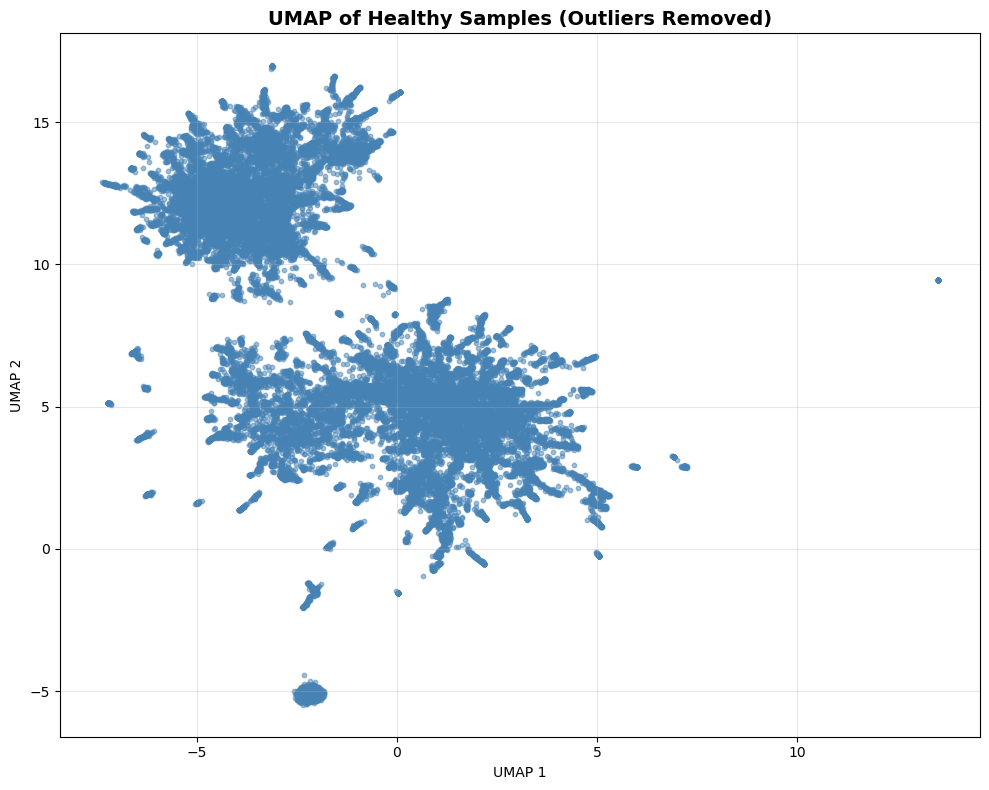


  - Creating visualizations for disease samples...
  - Computing UMAP for disease samples (this may take a few minutes)...
✓ Saved: disease_samples_umap.png


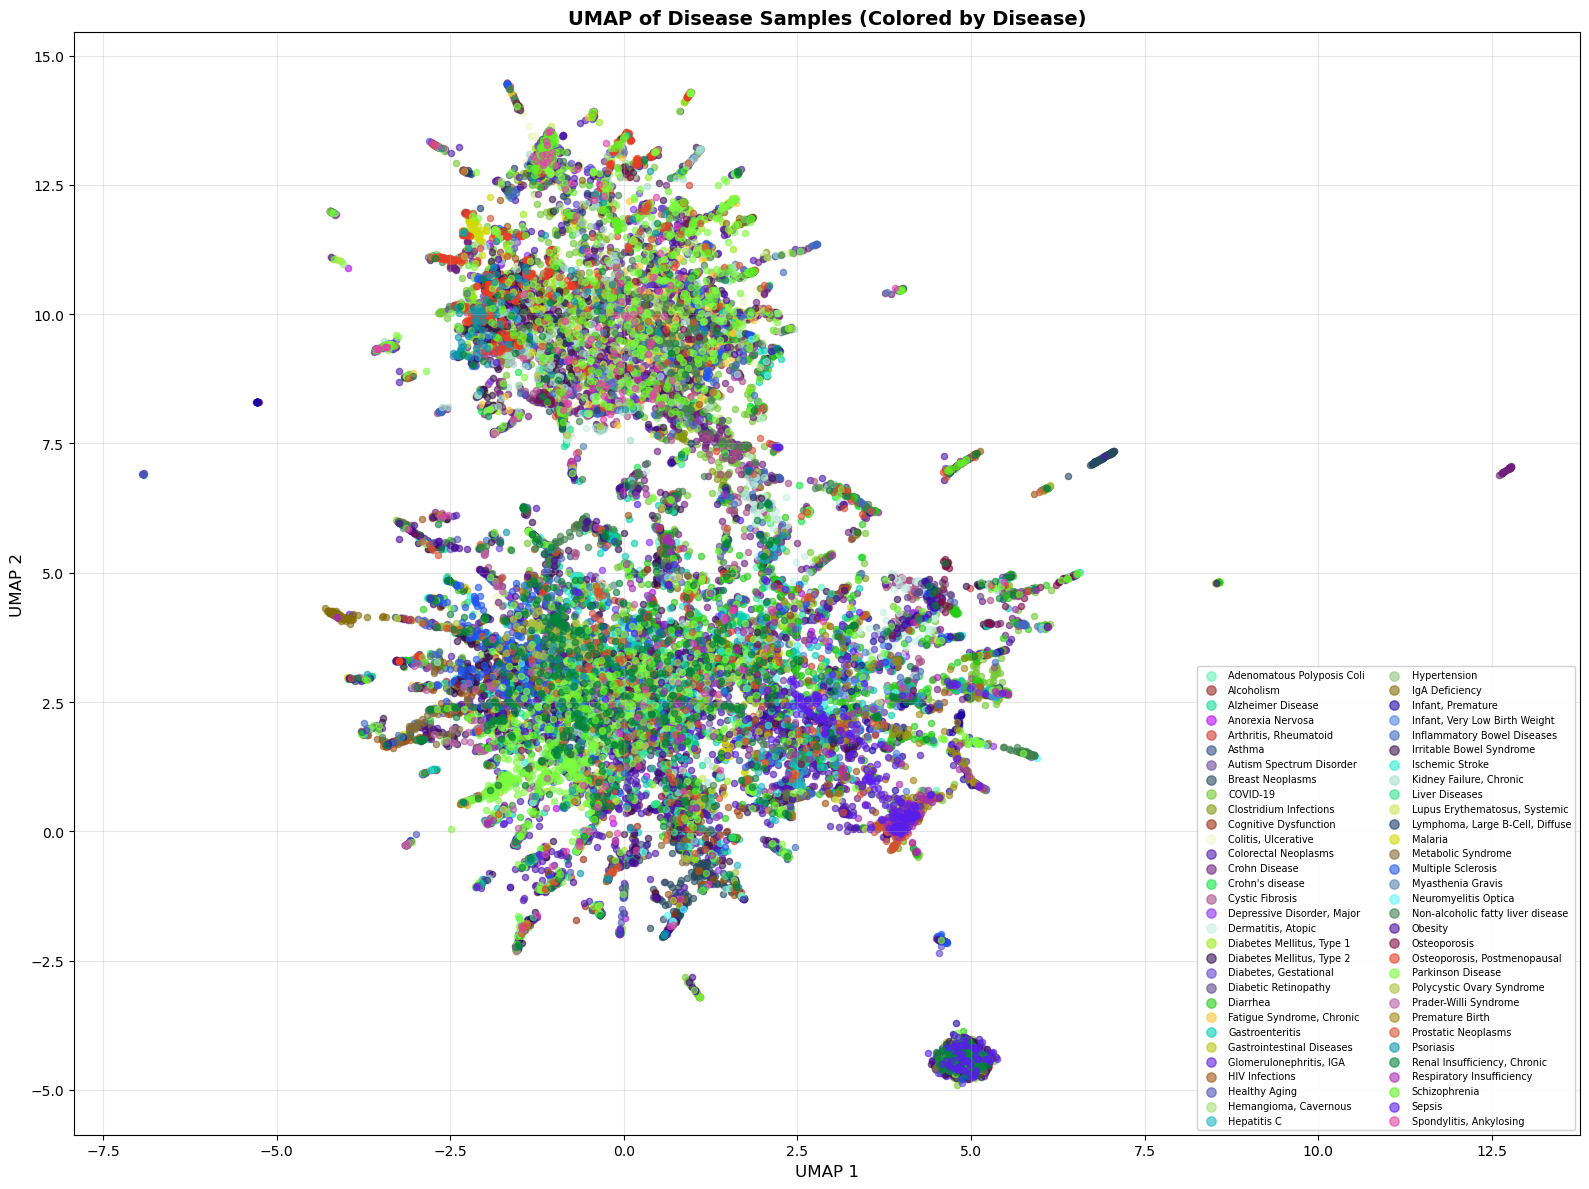

  - Creating combined healthy vs disease visualization...
  - Computing UMAP for combined data...
✓ Saved: combined_healthy_disease_umap.png


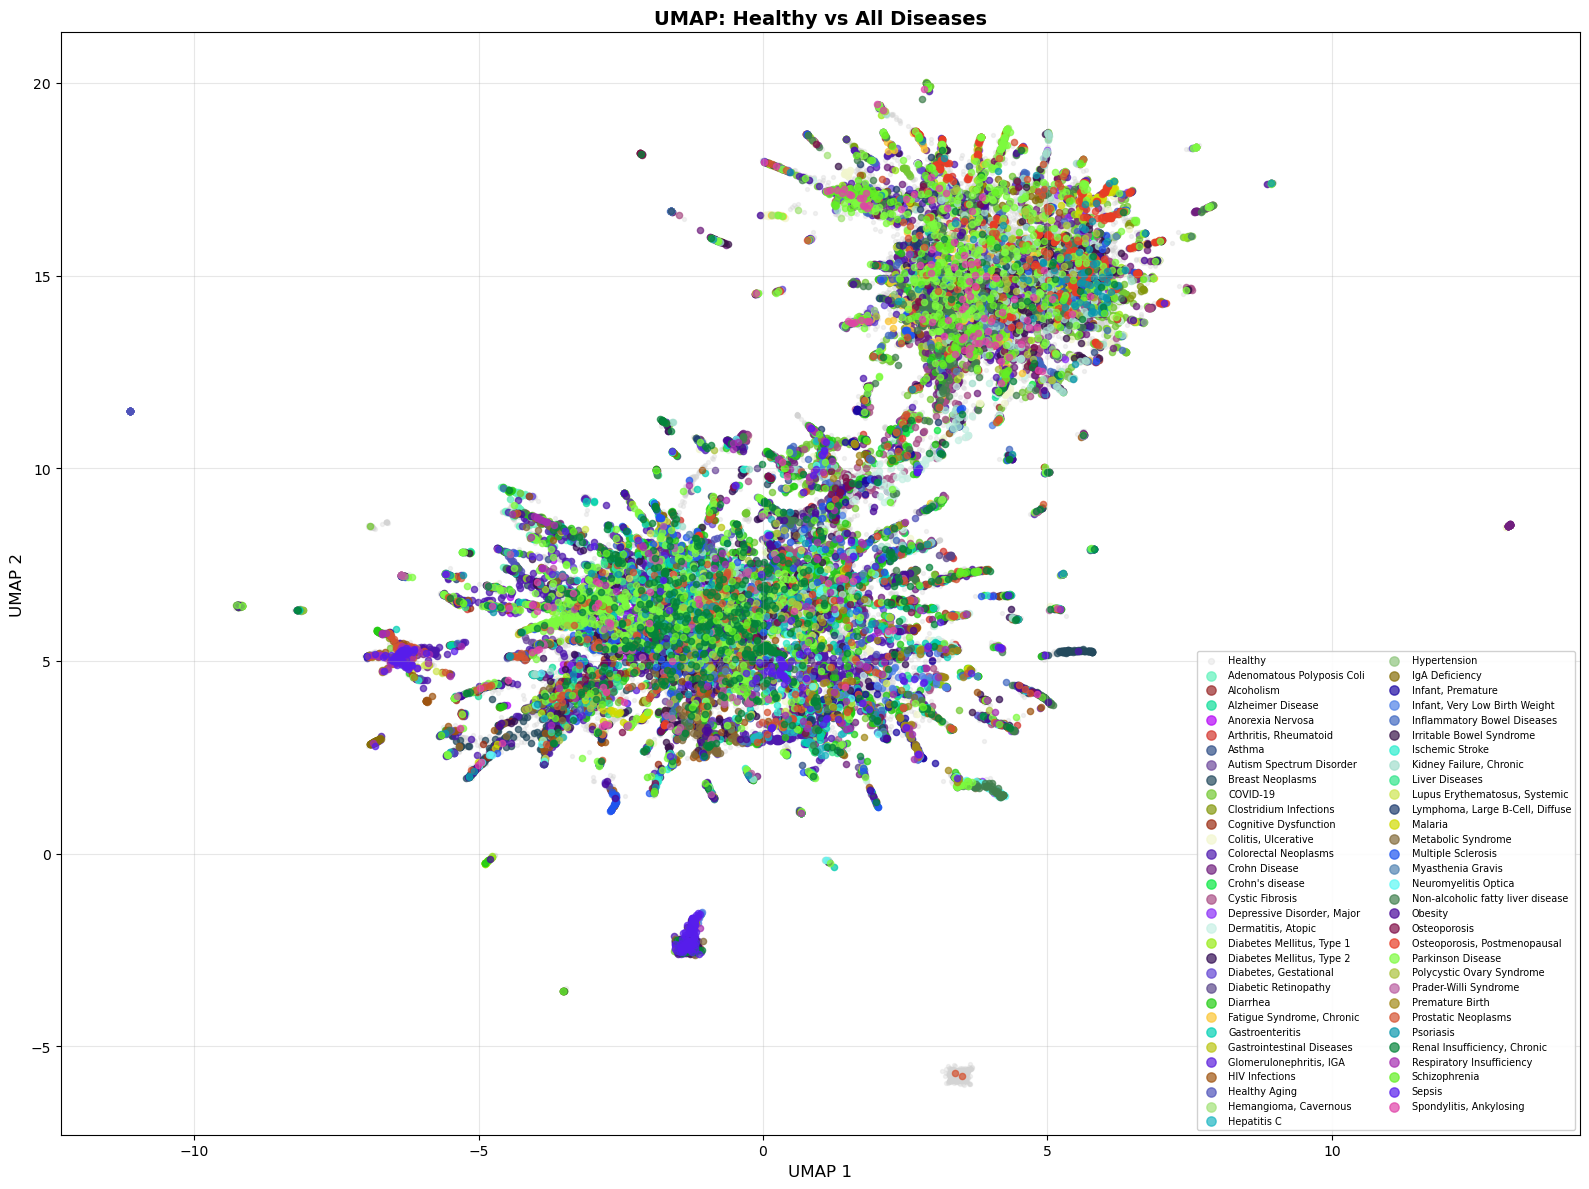


✓ Created visualizations for 62 disease types


In [56]:
# ============================================================================
# 6. VISUALIZATION - HEALTHY SAMPLES (UMAP)
# ============================================================================
print("\n[6/8] Creating visualizations...")

# Re-standardize after outlier removal
healthy_standardized = scaler.fit_transform(pivoted_df_Healthy)

# UMAP
print("  - Computing UMAP for healthy samples (this may take a few minutes)...")
umap_reducer = umap.UMAP(n_components=2, random_state=RANDOM_SEED, n_neighbors=15, min_dist=0.1)
umap_result = umap_reducer.fit_transform(healthy_standardized)

# Plot
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# UMAP plot
ax.scatter(umap_result[:, 0], umap_result[:, 1], alpha=0.5, s=10, color='steelblue')
ax.set_title('UMAP of Healthy Samples (Outliers Removed)', fontsize=14, fontweight='bold')
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('healthy_samples_umap.png', dpi=300, bbox_inches='tight')
print("✓ Saved: healthy_samples_umap.png")
plt.show()  # Display the plot
plt.close()

# ============================================================================
# 6b. VISUALIZATION - NON-HEALTHY SAMPLES (UMAP) COLORED BY DISEASE
# ============================================================================
print("\n  - Creating visualizations for disease samples...")

# Standardize non-healthy samples
non_healthy_standardized = scaler.fit_transform(pivoted_df_non_Healthy)

# UMAP for non-healthy
print("  - Computing UMAP for disease samples (this may take a few minutes)...")
umap_reducer_nh = umap.UMAP(n_components=2, random_state=RANDOM_SEED, n_neighbors=15, min_dist=0.1)
umap_result_nh = umap_reducer_nh.fit_transform(non_healthy_standardized)

# Get unique diseases and create color map with random colors
unique_diseases = sorted(non_healthy_metadata['phenotype'].unique())  # Sort for consistency
n_diseases = len(unique_diseases)

# Generate random colors with seed
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
disease_colors = {}
for disease in unique_diseases:
    disease_colors[disease] = (np.random.random(), np.random.random(), np.random.random())

# Create figure
fig, ax = plt.subplots(1, 1, figsize=(16, 12))

# UMAP plot
for disease in unique_diseases:
    mask = non_healthy_metadata['phenotype'] == disease
    ax.scatter(umap_result_nh[mask, 0], umap_result_nh[mask, 1], 
               alpha=0.6, s=20, color=disease_colors[disease], label=disease)

ax.set_title('UMAP of Disease Samples (Colored by Disease)', fontsize=14, fontweight='bold')
ax.set_xlabel('UMAP 1', fontsize=12)
ax.set_ylabel('UMAP 2', fontsize=12)
ax.grid(alpha=0.3)

# Add legend inside the plot area
ax.legend(loc='best', fontsize=7, ncol=2, framealpha=0.9, markerscale=1.5)

plt.tight_layout()
plt.savefig('disease_samples_umap.png', dpi=300, bbox_inches='tight')
print("✓ Saved: disease_samples_umap.png")
plt.show()  # Display the plot
plt.close()

# Create a combined visualization: Healthy vs All Diseases
print("  - Creating combined healthy vs disease visualization...")

# Combine data
combined_data = np.vstack([healthy_standardized, non_healthy_standardized])
combined_labels = ['Healthy'] * len(pivoted_df_Healthy) + non_healthy_metadata['phenotype'].tolist()

# UMAP for combined
print("  - Computing UMAP for combined data...")
umap_reducer_combined = umap.UMAP(n_components=2, random_state=RANDOM_SEED, n_neighbors=15, min_dist=0.1)
umap_result_combined = umap_reducer_combined.fit_transform(combined_data)

# Create figure
fig, ax = plt.subplots(1, 1, figsize=(16, 12))

# Plot healthy samples first (in background)
healthy_mask = np.array(combined_labels) == 'Healthy'
ax.scatter(umap_result_combined[healthy_mask, 0], umap_result_combined[healthy_mask, 1], 
           alpha=0.3, s=8, color='lightgray', label='Healthy')

# Plot disease samples on top
for disease in unique_diseases:
    disease_mask = np.array(combined_labels) == disease
    ax.scatter(umap_result_combined[disease_mask, 0], umap_result_combined[disease_mask, 1], 
               alpha=0.7, s=20, color=disease_colors[disease], label=disease)

ax.set_title('UMAP: Healthy vs All Diseases', fontsize=14, fontweight='bold')
ax.set_xlabel('UMAP 1', fontsize=12)
ax.set_ylabel('UMAP 2', fontsize=12)
ax.grid(alpha=0.3)

# Add legend inside the plot
ax.legend(loc='best', fontsize=7, ncol=2, framealpha=0.9, markerscale=1.5)

plt.tight_layout()
plt.savefig('combined_healthy_disease_umap.png', dpi=300, bbox_inches='tight')
print("✓ Saved: combined_healthy_disease_umap.png")
plt.show()  # Display the plot
plt.close()

print(f"\n✓ Created visualizations for {n_diseases} disease types")

In [57]:
# ============================================================================
# 7. DISEASE CLASSIFICATION LOOP (FINAL — robust to dtypes, shapes, duplicates)
# ============================================================================
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import umap
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split
from sklearn.metrics import roc_auc_score, f1_score
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests
import warnings

# Ensure RANDOM_SEED exists
try:
    RANDOM_SEED
except NameError:
    RANDOM_SEED = 42

print("\n[7/8] Training disease classifiers...")

# -------------------------
# ASSUMPTION: these exist
# metadata_df, pivoted_df_filtered, pivoted_df_Healthy, healthy_metadata
# -------------------------
non_healthy_metadata = metadata_df[metadata_df["phenotype"] != "Healthy"].reset_index(drop=True)
pivoted_df_non_Healthy = pivoted_df_filtered.loc[
    metadata_df[metadata_df["phenotype"] != "Healthy"].index
].reset_index(drop=True)

all_results = []
feature_importance_dict = {}

diseases = non_healthy_metadata["phenotype"].unique()
print(f"\nProcessing {len(diseases)} diseases...")

# helper: safely extract numeric 1-D series from a DataFrame selection
def safe_1d_numeric(series_like):
    """
    Accepts a pandas Series or DataFrame column selection and returns a
    1-D pd.Series of numeric values with NaNs removed.
    """
    # Convert to numpy and ravel to ensure 1D
    arr = np.asarray(series_like)
    arr = arr.ravel()
    s = pd.Series(arr)
    s = pd.to_numeric(s, errors="coerce").replace([np.inf, -np.inf], np.nan).dropna()
    return s

for disease in tqdm(diseases, desc="Disease classification"):

    print(f"\n{'='*80}")
    print(f"Processing: {disease}")
    print(f"{'='*80}")

    # 7.1 Subset disease samples
    disease_mask = non_healthy_metadata["phenotype"] == disease
    disease_metadata_subset = non_healthy_metadata[disease_mask].reset_index(drop=True)
    disease_data = pivoted_df_non_Healthy[disease_mask].reset_index(drop=True)

    n_disease = len(disease_data)
    n_healthy_total = len(pivoted_df_Healthy)

    print(f"  Disease samples: {n_disease}")
    print(f"  Healthy samples total: {n_healthy_total}")

    if n_disease < 5:
        print(f"  Skipping {disease}: too few disease samples (<5).")
        continue

    # 7.2 Balance classes by subsampling healthy controls (+25% headroom)
    healthy_sample_size = max(5, int(n_disease * 1.25))  # enforce min sample size
    replace_flag = healthy_sample_size > n_healthy_total
    rng = np.random.RandomState(RANDOM_SEED)
    healthy_idx = rng.choice(n_healthy_total, size=healthy_sample_size, replace=replace_flag)

    balanced_healthy_data = pivoted_df_Healthy.iloc[healthy_idx].reset_index(drop=True)
    balanced_healthy_labels = healthy_metadata.iloc[healthy_idx].reset_index(drop=True)

    print(f"  Balanced healthy samples: {len(balanced_healthy_data)} (replace={replace_flag})")

    # 7.3 Feature selection (robust)
    print("  Performing feature selection...")

    combined_data_fs = pd.concat([balanced_healthy_data, disease_data], axis=0).reset_index(drop=True)
    combined_labels_fs = pd.Series([0] * len(balanced_healthy_data) + [1] * len(disease_data), dtype=int)

    mw_pvalues = []
    tested_features = []

    # Only try numeric-ish columns as candidates (but still robustly handle odd objects)
    candidate_columns = combined_data_fs.columns.tolist()

    for col in candidate_columns:
        try:
            # Use safe_1d_numeric on each group's values
            healthy_vals = safe_1d_numeric(combined_data_fs.loc[combined_labels_fs == 0, col])
            disease_vals = safe_1d_numeric(combined_data_fs.loc[combined_labels_fs == 1, col])
        except Exception:
            # If extraction failed for this column, skip it
            continue

        # Need enough samples in both groups
        if len(healthy_vals) < 5 or len(disease_vals) < 5:
            continue

        # compute scalar stds (explicit float)
        healthy_std = float(healthy_vals.std()) if not healthy_vals.empty else np.nan
        disease_std = float(disease_vals.std()) if not disease_vals.empty else np.nan

        if np.isnan(healthy_std) or np.isnan(disease_std):
            continue
        if healthy_std <= 1e-6 or disease_std <= 1e-6:
            continue

        # Mann-Whitney U test
        try:
            _, p_val = mannwhitneyu(healthy_vals, disease_vals, alternative="two-sided")
            mw_pvalues.append(p_val)
            tested_features.append(col)
        except Exception:
            # skip feature on any statistical failure
            continue

    print(f"  Features tested: {len(tested_features)}")

    # Multiple-test correction
    selected_features = []
    if len(tested_features) > 0:
        try:
            reject, pvals_corrected, _, _ = multipletests(mw_pvalues, alpha=0.05, method="fdr_bh")
            selected_features = [tested_features[i] for i in range(len(tested_features)) if reject[i]]
        except Exception:
            selected_features = []

    # Limit to MAX_FEATURES
    MAX_FEATURES = 500
    if len(selected_features) > MAX_FEATURES:
        # keep by smallest raw p-value
        df_p = pd.DataFrame({"feature": tested_features, "p": mw_pvalues}).sort_values("p")
        selected_features = df_p.head(MAX_FEATURES)["feature"].tolist()

    # Fallback - use high variance numeric features (safe)
    if len(selected_features) < 10:
        print("  Warning: Few significant features found — using top-variance fallback.")
        numeric_df = combined_data_fs.apply(pd.to_numeric, errors="coerce").select_dtypes(include=[np.number])
        if numeric_df.shape[1] == 0:
            print(f"  Skipping {disease}: no numeric features available for fallback.")
            continue
        variances = numeric_df.var().dropna()
        if variances.empty:
            print(f"  Skipping {disease}: variance fallback produced no features.")
            continue
        selected_features = variances.sort_values(ascending=False).head(100).index.tolist()

    # Deduplicate selected features while preserving order
    seen = set()
    dedup_sel = []
    for f in selected_features:
        if f not in seen:
            seen.add(f)
            dedup_sel.append(f)
    selected_features = dedup_sel

    print(f"  Final selected features (count): {len(selected_features)}")

    # 7.4 Build final X, y using selected features
    try:
        healthy_feat = balanced_healthy_data[selected_features].reset_index(drop=True)
        disease_feat = disease_data[selected_features].reset_index(drop=True)
    except KeyError as e:
        print(f"  KeyError while subsetting features: {e}")
        print("  Skipping this disease.")
        continue
    except Exception as e:
        print(f"  Unexpected error while subsetting features: {e}")
        print("  Skipping this disease.")
        continue

    X = pd.concat([healthy_feat, disease_feat], axis=0).reset_index(drop=True)
    y = pd.Series([0] * len(healthy_feat) + [1] * len(disease_feat), dtype=int)

    print(f"  Final dataset shape (before cleanup): {X.shape}")
    print(f"  Class distribution: Healthy={(y==0).sum()}, {disease}={(y==1).sum()}")

    # 7.4b Collapse duplicate columns (if any) by mean — prevents ambiguous selections
    if X.columns.duplicated().any():
        dup_count = int(X.columns.duplicated().sum())
        print(f"  Collapsing {dup_count} duplicate columns (by column name) using mean.")
        # groupby on column names (axis=1) and aggregate by mean
        X = X.groupby(X.columns, axis=1).mean()

    # 7.4c Convert all columns to numeric (coerce), drop columns that become all-NaN
    X = X.apply(lambda col: pd.to_numeric(col, errors="coerce"))
    X = X.replace([np.inf, -np.inf], np.nan)
    X = X.dropna(axis=1, how="all")  # drop features with no numeric data

    if X.shape[1] == 0:
        print(f"  Skipping {disease}: no usable numeric features after coercion.")
        continue

    # 7.4d Final assurance: ensure columns are unique and ordered
    X = X.loc[:, ~X.columns.duplicated()]

    # 7.4e Convert to numpy float matrix for model input
    try:
        X_mat = np.asarray(X.values, dtype=float, order="C")
    except Exception as e:
        print(f"  Failed to convert X to numeric matrix: {e}. Skipping {disease}.")
        continue

        # 7.5 UMAP visualization (INTERACTIVE 3D — Plotly)
    try:
        import plotly.graph_objects as go
        print(f"    Creating 3D UMAP visualization...")
        
        # Debug: Check data shapes
        print(f"    X_mat shape: {X_mat.shape}")
        print(f"    y shape: {y.shape}")
        
        # Scale the data
        from sklearn.preprocessing import StandardScaler
        X_scaled = StandardScaler().fit_transform(X_mat)
        
        # Create UMAP model
        umap_model = umap.UMAP(
            n_components=3,
            random_state=RANDOM_SEED,
            n_neighbors=15,
            min_dist=0.1
        )
        umap_coords = umap_model.fit_transform(X_scaled)
        
        # Debug: Check UMAP output
        print(f"    UMAP coordinates shape: {umap_coords.shape}")
        
        # Split by class
        umap_healthy = umap_coords[y == 0]
        umap_disease = umap_coords[y == 1]
        
        print(f"    Healthy samples in UMAP: {umap_healthy.shape[0]}")
        print(f"    Disease samples in UMAP: {umap_disease.shape[0]}")
        
        fig = go.Figure()

        fig.add_trace(go.Scatter3d(
            x=umap_healthy[:, 0],
            y=umap_healthy[:, 1],
            z=umap_healthy[:, 2],
            mode="markers",
            name="Healthy",
            marker=dict(size=4, opacity=0.6, color='#2E86AB'),
        ))

        fig.add_trace(go.Scatter3d(
            x=umap_disease[:, 0],
            y=umap_disease[:, 1],
            z=umap_disease[:, 2],
            mode="markers",
            name=str(disease),
            marker=dict(size=4, opacity=0.6, color='#A23B72'),
        ))

        fig.update_layout(
            title=f"3D UMAP: Healthy vs {disease}",
            scene=dict(
                xaxis_title="UMAP 1",
                yaxis_title="UMAP 2",
                zaxis_title="UMAP 3",
            ),
            legend=dict(itemsizing="constant"),
            margin=dict(l=0, r=0, b=0, t=40),
        )
        
        # Create safe filename
        safe_name = str(disease).replace("/", "_").replace(" ", "_")
        html_filename = f"{safe_name}_umap_3D.html"
        
        # Check current directory
        import os
        current_dir = os.getcwd()
        print(f"    Current directory: {current_dir}")
        print(f"    Saving to: {html_filename}")
        
        # Save the HTML file
        fig.write_html(html_filename, include_plotlyjs="cdn")
        
        # Verify file was created
        if os.path.exists(html_filename):
            file_size = os.path.getsize(html_filename)
            print(f"    ✓ Successfully saved HTML file: {html_filename} ({file_size} bytes)")
        else:
            print(f"    ✗ ERROR: HTML file was not created: {html_filename}")

    except Exception as e:
        print(f"    ✗ ERROR creating 3D UMAP for {disease}: {str(e)}")
        import traceback
        traceback.print_exc()



    # 7.6 XGBoost Training with Cross-Validation (defensive)
    print("  Training XGBoost classifier...")

    # Build model
    model = xgb.XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=RANDOM_SEED,
        eval_metric="logloss",
        use_label_encoder=False,
        n_jobs=-1,
        verbosity=0
    )

    # Choose n_splits: cannot exceed the minimum class count
    class_counts = y.value_counts()
    min_class_count = int(class_counts.min())
    if min_class_count < 2:
        print(f"  Skipping {disease}: not enough samples per class for CV (min_class={min_class_count}).")
        continue
    n_splits = min(5, min_class_count)

    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)
    scoring = ["roc_auc", "f1"]

    # Attempt CV; if it fails, fallback to single split training
    try:
        cv_results = cross_validate(
            model,
            X_mat,
            y.values,
            cv=cv,
            scoring=scoring,
            n_jobs=-1,
            return_train_score=False,
            error_score="raise"  # raise errors so we can handle explicitly
        )
    except Exception as e_cv:
        print(f"  cross_validate failed for {disease}: {e_cv}")
        print("  Attempting fallback: single train/test split.")
        try:
            X_train, X_test, y_train, y_test = train_test_split(
                X_mat, y.values, test_size=0.2, stratify=y.values, random_state=RANDOM_SEED
            )
            model.fit(X_train, y_train)
            y_pred_train = model.predict(X_train)
            y_proba_train = model.predict_proba(X_train)[:, 1] if hasattr(model, "predict_proba") else y_pred_train.astype(float)
            train_roc = roc_auc_score(y_train, y_proba_train) if len(np.unique(y_train)) > 1 else np.nan
            train_f1 = f1_score(y_train, y_pred_train, zero_division=0)
            all_results.append({
                "Disease": disease,
                "N_Disease": n_disease,
                "N_Healthy_Balanced": len(balanced_healthy_data),
                "N_Features": X.shape[1],
                "CV_ROC_AUC_Mean": np.nan,
                "CV_F1_Mean": np.nan,
                "Train_ROC_AUC": float(train_roc) if not np.isnan(train_roc) else np.nan,
                "Train_F1": float(train_f1)
            })
            # Save feature importance if available
            try:
                fi = model.feature_importances_
                feature_importance_dict[disease] = pd.DataFrame({
                    "feature": X.columns.tolist(),
                    "importance": fi[: len(X.columns)]
                }).sort_values("importance", ascending=False)
            except Exception:
                feature_importance_dict[disease] = pd.DataFrame({
                    "feature": X.columns.tolist(),
                    "importance": np.zeros(len(X.columns))
                })
            print(f"  Fallback training complete for {disease}.")
            continue
        except Exception as e_fb:
            print(f"  Fallback training also failed for {disease}: {e_fb}")
            continue

    # If CV succeeded, fit on full data
    try:
        model.fit(X_mat, y.values)
    except Exception as e_fit:
        print(f"  Full-data training failed for {disease}: {e_fit}")
        continue

    # Predictions & metrics
    try:
        y_pred = model.predict(X_mat)
        y_proba = model.predict_proba(X_mat)[:, 1] if hasattr(model, "predict_proba") else y_pred.astype(float)
    except Exception as e_pred:
        print(f"  Prediction failed for {disease}: {e_pred}")
        continue

    # Compute metrics safely
    cv_roc_mean = float(np.mean(cv_results["test_roc_auc"])) if "test_roc_auc" in cv_results and len(cv_results["test_roc_auc"]) > 0 else np.nan
    cv_f1_mean = float(np.mean(cv_results["test_f1"])) if "test_f1" in cv_results and len(cv_results["test_f1"]) > 0 else np.nan
    train_roc = float(roc_auc_score(y.values, y_proba)) if len(np.unique(y.values)) > 1 else np.nan
    train_f1 = float(f1_score(y.values, y_pred, zero_division=0))

    all_results.append({
        "Disease": disease,
        "N_Disease": n_disease,
        "N_Healthy_Balanced": len(balanced_healthy_data),
        "N_Features": X.shape[1],
        "CV_ROC_AUC_Mean": cv_roc_mean,
        "CV_F1_Mean": cv_f1_mean,
        "Train_ROC_AUC": train_roc,
        "Train_F1": train_f1
    })

    # Feature importance (aligned defensively)
    try:
        fi = model.feature_importances_
        feature_importance_dict[disease] = pd.DataFrame({
            "feature": X.columns.tolist(),
            "importance": fi[: len(X.columns)]
        }).sort_values("importance", ascending=False)
    except Exception:
        feature_importance_dict[disease] = pd.DataFrame({
            "feature": X.columns.tolist(),
            "importance": np.zeros(len(X.columns))
        })

    print(f"  ✓ CV ROC-AUC: {cv_roc_mean if not np.isnan(cv_roc_mean) else 'nan'}")
    print(f"  ✓ CV F1: {cv_f1_mean if not np.isnan(cv_f1_mean) else 'nan'}")

# End loop
print("\nDone — disease loop finished. Collected results for", len(all_results), "diseases.")



[7/8] Training disease classifiers...

Processing 62 diseases...


Disease classification:   0%|                            | 0/62 [00:00<?, ?it/s]


Processing: Obesity
  Disease samples: 383
  Healthy samples total: 29559
  Balanced healthy samples: 478 (replace=False)
  Performing feature selection...
  Features tested: 297
  Final selected features (count): 84
  Final dataset shape (before cleanup): (861, 87)
  Class distribution: Healthy=478, Obesity=383
  Collapsing 3 duplicate columns (by column name) using mean.
    Creating 3D UMAP visualization...
    X_mat shape: (861, 84)
    y shape: (861,)
    UMAP coordinates shape: (861, 3)
    Healthy samples in UMAP: 478
    Disease samples in UMAP: 383
    Current directory: /home/cesc/Desktop/dis_class
    Saving to: Obesity_umap_3D.html
    ✓ Successfully saved HTML file: Obesity_umap_3D.html (22791 bytes)
  Training XGBoost classifier...


Disease classification:   2%|▎                   | 1/62 [00:05<06:04,  5.98s/it]

  ✓ CV ROC-AUC: 0.8681384213374346
  ✓ CV F1: 0.7494619750530168

Processing: Diabetic Retinopathy
  Disease samples: 188
  Healthy samples total: 29559
  Balanced healthy samples: 235 (replace=False)
  Performing feature selection...
  Features tested: 198
  Final selected features (count): 61
  Final dataset shape (before cleanup): (423, 61)
  Class distribution: Healthy=235, Diabetic Retinopathy=188
    Creating 3D UMAP visualization...
    X_mat shape: (423, 61)
    y shape: (423,)
    UMAP coordinates shape: (423, 3)
    Healthy samples in UMAP: 235
    Disease samples in UMAP: 188
    Current directory: /home/cesc/Desktop/dis_class
    Saving to: Diabetic_Retinopathy_umap_3D.html
    ✓ Successfully saved HTML file: Diabetic_Retinopathy_umap_3D.html (15399 bytes)
  Training XGBoost classifier...


Disease classification:   3%|▋                   | 2/62 [00:10<05:13,  5.22s/it]

  ✓ CV ROC-AUC: 0.9655882085893284
  ✓ CV F1: 0.8757666752848369

Processing: Glomerulonephritis, IGA
  Disease samples: 152
  Healthy samples total: 29559
  Balanced healthy samples: 190 (replace=False)
  Performing feature selection...
  Features tested: 203
  Final selected features (count): 92
  Final dataset shape (before cleanup): (342, 93)
  Class distribution: Healthy=190, Glomerulonephritis, IGA=152
  Collapsing 1 duplicate columns (by column name) using mean.
    Creating 3D UMAP visualization...
    X_mat shape: (342, 92)
    y shape: (342,)
    UMAP coordinates shape: (342, 3)
    Healthy samples in UMAP: 190
    Disease samples in UMAP: 152
    Current directory: /home/cesc/Desktop/dis_class
    Saving to: Glomerulonephritis,_IGA_umap_3D.html
    ✓ Successfully saved HTML file: Glomerulonephritis,_IGA_umap_3D.html (13974 bytes)
  Training XGBoost classifier...


Disease classification:   5%|▉                   | 3/62 [00:14<04:43,  4.80s/it]

  ✓ CV ROC-AUC: 0.9468590831918506
  ✓ CV F1: 0.842421627840092

Processing: Schizophrenia
  Disease samples: 277
  Healthy samples total: 29559
  Balanced healthy samples: 346 (replace=False)
  Performing feature selection...
  Features tested: 276
  Final selected features (count): 117
  Final dataset shape (before cleanup): (623, 119)
  Class distribution: Healthy=346, Schizophrenia=277
  Collapsing 2 duplicate columns (by column name) using mean.
    Creating 3D UMAP visualization...
    X_mat shape: (623, 117)
    y shape: (623,)
    UMAP coordinates shape: (623, 3)
    Healthy samples in UMAP: 346
    Disease samples in UMAP: 277
    Current directory: /home/cesc/Desktop/dis_class
    Saving to: Schizophrenia_umap_3D.html
    ✓ Successfully saved HTML file: Schizophrenia_umap_3D.html (19314 bytes)
  Training XGBoost classifier...


Disease classification:   6%|█▎                  | 4/62 [00:20<04:58,  5.15s/it]

  ✓ CV ROC-AUC: 0.9428469791078486
  ✓ CV F1: 0.839889030752983

Processing: Multiple Sclerosis
  Disease samples: 514
  Healthy samples total: 29559
  Balanced healthy samples: 642 (replace=False)
  Performing feature selection...
  Features tested: 287
  Final selected features (count): 134
  Final dataset shape (before cleanup): (1156, 137)
  Class distribution: Healthy=642, Multiple Sclerosis=514
  Collapsing 3 duplicate columns (by column name) using mean.
    Creating 3D UMAP visualization...
    X_mat shape: (1156, 134)
    y shape: (1156,)
    UMAP coordinates shape: (1156, 3)
    Healthy samples in UMAP: 642
    Disease samples in UMAP: 514
    Current directory: /home/cesc/Desktop/dis_class
    Saving to: Multiple_Sclerosis_umap_3D.html
    ✓ Successfully saved HTML file: Multiple_Sclerosis_umap_3D.html (27594 bytes)
  Training XGBoost classifier...


Disease classification:   8%|█▌                  | 5/62 [00:27<05:31,  5.82s/it]

  ✓ CV ROC-AUC: 0.9295630002678423
  ✓ CV F1: 0.8295175668850548

Processing: Diabetes Mellitus, Type 2
  Disease samples: 900
  Healthy samples total: 29559
  Balanced healthy samples: 1125 (replace=False)
  Performing feature selection...
  Features tested: 377
  Final selected features (count): 180
  Final dataset shape (before cleanup): (2025, 182)
  Class distribution: Healthy=1125, Diabetes Mellitus, Type 2=900
  Collapsing 2 duplicate columns (by column name) using mean.
    Creating 3D UMAP visualization...
    X_mat shape: (2025, 180)
    y shape: (2025,)
    UMAP coordinates shape: (2025, 3)
    Healthy samples in UMAP: 1125
    Disease samples in UMAP: 900
    Current directory: /home/cesc/Desktop/dis_class
    Saving to: Diabetes_Mellitus,_Type_2_umap_3D.html
    ✓ Successfully saved HTML file: Diabetes_Mellitus,_Type_2_umap_3D.html (46679 bytes)
  Training XGBoost classifier...


Disease classification:  10%|█▉                  | 6/62 [00:37<06:48,  7.29s/it]

  ✓ CV ROC-AUC: 0.933404938271605
  ✓ CV F1: 0.8307685011840947

Processing: Gastrointestinal Diseases
  Disease samples: 174
  Healthy samples total: 29559
  Balanced healthy samples: 217 (replace=False)
  Performing feature selection...
  Features tested: 199
  Final selected features (count): 62
  Final dataset shape (before cleanup): (391, 63)
  Class distribution: Healthy=217, Gastrointestinal Diseases=174
  Collapsing 1 duplicate columns (by column name) using mean.
    Creating 3D UMAP visualization...
    X_mat shape: (391, 62)
    y shape: (391,)
    UMAP coordinates shape: (391, 3)
    Healthy samples in UMAP: 217
    Disease samples in UMAP: 174
    Current directory: /home/cesc/Desktop/dis_class
    Saving to: Gastrointestinal_Diseases_umap_3D.html
    ✓ Successfully saved HTML file: Gastrointestinal_Diseases_umap_3D.html (14998 bytes)
  Training XGBoost classifier...


Disease classification:  11%|██▎                 | 7/62 [00:43<06:17,  6.86s/it]

  ✓ CV ROC-AUC: 0.9442706131078225
  ✓ CV F1: 0.8880814486363299

Processing: Metabolic Syndrome
  Disease samples: 200
  Healthy samples total: 29559
  Balanced healthy samples: 250 (replace=False)
  Performing feature selection...
  Features tested: 208
  Final selected features (count): 123
  Final dataset shape (before cleanup): (450, 125)
  Class distribution: Healthy=250, Metabolic Syndrome=200
  Collapsing 2 duplicate columns (by column name) using mean.
    Creating 3D UMAP visualization...
    X_mat shape: (450, 123)
    y shape: (450,)


Disease classification:  13%|██▌                 | 8/62 [00:48<05:29,  6.10s/it]

    UMAP coordinates shape: (450, 3)
    Healthy samples in UMAP: 250
    Disease samples in UMAP: 200
    Current directory: /home/cesc/Desktop/dis_class
    Saving to: Metabolic_Syndrome_umap_3D.html
    ✓ Successfully saved HTML file: Metabolic_Syndrome_umap_3D.html (15782 bytes)
  Training XGBoost classifier...
  ✓ CV ROC-AUC: 0.9803499999999999
  ✓ CV F1: 0.9262037793542746

Processing: Irritable Bowel Syndrome
  Disease samples: 672
  Healthy samples total: 29559
  Balanced healthy samples: 840 (replace=False)
  Performing feature selection...
  Features tested: 329
  Final selected features (count): 137
  Final dataset shape (before cleanup): (1512, 139)
  Class distribution: Healthy=840, Irritable Bowel Syndrome=672
  Collapsing 2 duplicate columns (by column name) using mean.
    Creating 3D UMAP visualization...
    X_mat shape: (1512, 137)
    y shape: (1512,)
    UMAP coordinates shape: (1512, 3)
    Healthy samples in UMAP: 840
    Disease samples in UMAP: 672
    Current 

Disease classification:  15%|██▉                 | 9/62 [00:56<05:58,  6.76s/it]

  ✓ CV ROC-AUC: 0.9334708731474901
  ✓ CV F1: 0.8525439824628016

Processing: Autism Spectrum Disorder
  Disease samples: 417
  Healthy samples total: 29559
  Balanced healthy samples: 521 (replace=False)
  Performing feature selection...
  Features tested: 370
  Final selected features (count): 126
  Final dataset shape (before cleanup): (938, 129)
  Class distribution: Healthy=521, Autism Spectrum Disorder=417
  Collapsing 3 duplicate columns (by column name) using mean.
    Creating 3D UMAP visualization...
    X_mat shape: (938, 126)
    y shape: (938,)
    UMAP coordinates shape: (938, 3)
    Healthy samples in UMAP: 521
    Disease samples in UMAP: 417
    Current directory: /home/cesc/Desktop/dis_class
    Saving to: Autism_Spectrum_Disorder_umap_3D.html
    ✓ Successfully saved HTML file: Autism_Spectrum_Disorder_umap_3D.html (24839 bytes)
  Training XGBoost classifier...


Disease classification:  16%|███                | 10/62 [01:02<05:38,  6.50s/it]

  ✓ CV ROC-AUC: 0.9246895273401297
  ✓ CV F1: 0.8349202721008181

Processing: Parkinson Disease
  Disease samples: 1403
  Healthy samples total: 29559
  Balanced healthy samples: 1753 (replace=False)
  Performing feature selection...
  Features tested: 481
  Final selected features (count): 202
  Final dataset shape (before cleanup): (3156, 204)
  Class distribution: Healthy=1753, Parkinson Disease=1403
  Collapsing 2 duplicate columns (by column name) using mean.
    Creating 3D UMAP visualization...
    X_mat shape: (3156, 202)
    y shape: (3156,)
    UMAP coordinates shape: (3156, 3)
    Healthy samples in UMAP: 1753
    Disease samples in UMAP: 1403
    Current directory: /home/cesc/Desktop/dis_class
    Saving to: Parkinson_Disease_umap_3D.html
    ✓ Successfully saved HTML file: Parkinson_Disease_umap_3D.html (66686 bytes)
  Training XGBoost classifier...


Disease classification:  18%|███▎               | 11/62 [01:18<08:07,  9.55s/it]

  ✓ CV ROC-AUC: 0.9167969509731076
  ✓ CV F1: 0.8048281619678811

Processing: Inflammatory Bowel Diseases
  Disease samples: 458
  Healthy samples total: 29559
  Balanced healthy samples: 572 (replace=False)
  Performing feature selection...
  Features tested: 315
  Final selected features (count): 95
  Final dataset shape (before cleanup): (1030, 98)
  Class distribution: Healthy=572, Inflammatory Bowel Diseases=458
  Collapsing 3 duplicate columns (by column name) using mean.
    Creating 3D UMAP visualization...
    X_mat shape: (1030, 95)
    y shape: (1030,)
    UMAP coordinates shape: (1030, 3)
    Healthy samples in UMAP: 572
    Disease samples in UMAP: 458
    Current directory: /home/cesc/Desktop/dis_class
    Saving to: Inflammatory_Bowel_Diseases_umap_3D.html
    ✓ Successfully saved HTML file: Inflammatory_Bowel_Diseases_umap_3D.html (25541 bytes)
  Training XGBoost classifier...


Disease classification:  19%|███▋               | 12/62 [01:26<07:22,  8.85s/it]

  ✓ CV ROC-AUC: 0.9343544899036891
  ✓ CV F1: 0.8398204043585361

Processing: HIV Infections
  Disease samples: 520
  Healthy samples total: 29559
  Balanced healthy samples: 650 (replace=False)
  Performing feature selection...
  Features tested: 360
  Final selected features (count): 173
  Final dataset shape (before cleanup): (1170, 175)
  Class distribution: Healthy=650, HIV Infections=520
  Collapsing 2 duplicate columns (by column name) using mean.
    Creating 3D UMAP visualization...
    X_mat shape: (1170, 173)
    y shape: (1170,)
    UMAP coordinates shape: (1170, 3)
    Healthy samples in UMAP: 650
    Disease samples in UMAP: 520
    Current directory: /home/cesc/Desktop/dis_class
    Saving to: HIV_Infections_umap_3D.html
    ✓ Successfully saved HTML file: HIV_Infections_umap_3D.html (27864 bytes)
  Training XGBoost classifier...


Disease classification:  21%|███▉               | 13/62 [01:34<07:00,  8.59s/it]

  ✓ CV ROC-AUC: 0.9525443786982247
  ✓ CV F1: 0.8645376158162792

Processing: Colorectal Neoplasms
  Disease samples: 3083
  Healthy samples total: 29559
  Balanced healthy samples: 3853 (replace=False)
  Performing feature selection...
  Features tested: 724
  Final selected features (count): 350
  Final dataset shape (before cleanup): (6936, 354)
  Class distribution: Healthy=3853, Colorectal Neoplasms=3083
  Collapsing 4 duplicate columns (by column name) using mean.
    Creating 3D UMAP visualization...
    X_mat shape: (6936, 350)
    y shape: (6936,)
    UMAP coordinates shape: (6936, 3)
    Healthy samples in UMAP: 3853
    Disease samples in UMAP: 3083
    Current directory: /home/cesc/Desktop/dis_class
    Saving to: Colorectal_Neoplasms_umap_3D.html
    ✓ Successfully saved HTML file: Colorectal_Neoplasms_umap_3D.html (124577 bytes)
  Training XGBoost classifier...


Disease classification:  23%|████▎              | 14/62 [02:01<11:29, 14.36s/it]

  ✓ CV ROC-AUC: 0.9308139147312631
  ✓ CV F1: 0.838450540388453

Processing: Sepsis
  Disease samples: 279
  Healthy samples total: 29559
  Balanced healthy samples: 348 (replace=False)
  Performing feature selection...
  Features tested: 191
  Final selected features (count): 114
  Final dataset shape (before cleanup): (627, 115)
  Class distribution: Healthy=348, Sepsis=279
  Collapsing 1 duplicate columns (by column name) using mean.
    Creating 3D UMAP visualization...
    X_mat shape: (627, 114)
    y shape: (627,)
    UMAP coordinates shape: (627, 3)
    Healthy samples in UMAP: 348
    Disease samples in UMAP: 279
    Current directory: /home/cesc/Desktop/dis_class
    Saving to: Sepsis_umap_3D.html
    ✓ Successfully saved HTML file: Sepsis_umap_3D.html (19388 bytes)
  Training XGBoost classifier...


Disease classification:  24%|████▌              | 15/62 [02:08<09:25, 12.03s/it]

  ✓ CV ROC-AUC: 0.9547671882982443
  ✓ CV F1: 0.9007798148323468

Processing: Renal Insufficiency, Chronic
  Disease samples: 761
  Healthy samples total: 29559
  Balanced healthy samples: 951 (replace=False)
  Performing feature selection...
  Features tested: 369
  Final selected features (count): 162
  Final dataset shape (before cleanup): (1712, 164)
  Class distribution: Healthy=951, Renal Insufficiency, Chronic=761
  Collapsing 2 duplicate columns (by column name) using mean.
    Creating 3D UMAP visualization...
    X_mat shape: (1712, 162)
    y shape: (1712,)
    UMAP coordinates shape: (1712, 3)
    Healthy samples in UMAP: 951
    Disease samples in UMAP: 761
    Current directory: /home/cesc/Desktop/dis_class
    Saving to: Renal_Insufficiency,_Chronic_umap_3D.html
    ✓ Successfully saved HTML file: Renal_Insufficiency,_Chronic_umap_3D.html (37691 bytes)
  Training XGBoost classifier...


Disease classification:  26%|████▉              | 16/62 [02:17<08:36, 11.23s/it]

  ✓ CV ROC-AUC: 0.9049082271932622
  ✓ CV F1: 0.8120006517684709

Processing: Arthritis, Rheumatoid
  Disease samples: 386
  Healthy samples total: 29559
  Balanced healthy samples: 482 (replace=False)
  Performing feature selection...
  Features tested: 311
  Final selected features (count): 83
  Final dataset shape (before cleanup): (868, 84)
  Class distribution: Healthy=482, Arthritis, Rheumatoid=386
  Collapsing 1 duplicate columns (by column name) using mean.
    Creating 3D UMAP visualization...
    X_mat shape: (868, 83)
    y shape: (868,)
    UMAP coordinates shape: (868, 3)
    Healthy samples in UMAP: 482
    Disease samples in UMAP: 386
    Current directory: /home/cesc/Desktop/dis_class
    Saving to: Arthritis,_Rheumatoid_umap_3D.html
    ✓ Successfully saved HTML file: Arthritis,_Rheumatoid_umap_3D.html (23022 bytes)
  Training XGBoost classifier...


Disease classification:  27%|█████▏             | 17/62 [02:23<07:14,  9.65s/it]

  ✓ CV ROC-AUC: 0.9055629507949096
  ✓ CV F1: 0.8152709671620982

Processing: Kidney Failure, Chronic
  Disease samples: 487
  Healthy samples total: 29559
  Balanced healthy samples: 608 (replace=False)
  Performing feature selection...
  Features tested: 311
  Final selected features (count): 170
  Final dataset shape (before cleanup): (1095, 174)
  Class distribution: Healthy=608, Kidney Failure, Chronic=487
  Collapsing 4 duplicate columns (by column name) using mean.
    Creating 3D UMAP visualization...
    X_mat shape: (1095, 170)
    y shape: (1095,)
    UMAP coordinates shape: (1095, 3)
    Healthy samples in UMAP: 608
    Disease samples in UMAP: 487
    Current directory: /home/cesc/Desktop/dis_class
    Saving to: Kidney_Failure,_Chronic_umap_3D.html
    ✓ Successfully saved HTML file: Kidney_Failure,_Chronic_umap_3D.html (27407 bytes)
  Training XGBoost classifier...


Disease classification:  29%|█████▌             | 18/62 [02:30<06:32,  8.91s/it]

  ✓ CV ROC-AUC: 0.9802457923236926
  ✓ CV F1: 0.9233385238357104

Processing: Diabetes Mellitus, Type 1
  Disease samples: 604
  Healthy samples total: 29559
  Balanced healthy samples: 755 (replace=False)
  Performing feature selection...
  Features tested: 344
  Final selected features (count): 154
  Final dataset shape (before cleanup): (1359, 156)
  Class distribution: Healthy=755, Diabetes Mellitus, Type 1=604
  Collapsing 2 duplicate columns (by column name) using mean.
    Creating 3D UMAP visualization...
    X_mat shape: (1359, 154)
    y shape: (1359,)
    UMAP coordinates shape: (1359, 3)
    Healthy samples in UMAP: 755
    Disease samples in UMAP: 604
    Current directory: /home/cesc/Desktop/dis_class
    Saving to: Diabetes_Mellitus,_Type_1_umap_3D.html
    ✓ Successfully saved HTML file: Diabetes_Mellitus,_Type_1_umap_3D.html (31345 bytes)
  Training XGBoost classifier...


Disease classification:  31%|█████▊             | 19/62 [02:38<06:10,  8.61s/it]

  ✓ CV ROC-AUC: 0.9093839052779451
  ✓ CV F1: 0.7965133661997117

Processing: Asthma
  Disease samples: 254
  Healthy samples total: 29559
  Balanced healthy samples: 317 (replace=False)
  Performing feature selection...
  Features tested: 265
  Final selected features (count): 98
  Final dataset shape (before cleanup): (571, 100)
  Class distribution: Healthy=317, Asthma=254
  Collapsing 2 duplicate columns (by column name) using mean.
    Creating 3D UMAP visualization...
    X_mat shape: (571, 98)
    y shape: (571,)
    UMAP coordinates shape: (571, 3)
    Healthy samples in UMAP: 317
    Disease samples in UMAP: 254
    Current directory: /home/cesc/Desktop/dis_class
    Saving to: Asthma_umap_3D.html
    ✓ Successfully saved HTML file: Asthma_umap_3D.html (17775 bytes)
  Training XGBoost classifier...


Disease classification:  32%|██████▏            | 20/62 [02:43<05:13,  7.47s/it]

  ✓ CV ROC-AUC: 0.9759555516651105
  ✓ CV F1: 0.9037381851587221

Processing: Ischemic Stroke
  Disease samples: 205
  Healthy samples total: 29559
  Balanced healthy samples: 256 (replace=False)
  Performing feature selection...
  Features tested: 187
  Final selected features (count): 84
  Final dataset shape (before cleanup): (461, 84)
  Class distribution: Healthy=256, Ischemic Stroke=205
    Creating 3D UMAP visualization...
    X_mat shape: (461, 84)
    y shape: (461,)
    UMAP coordinates shape: (461, 3)
    Healthy samples in UMAP: 256
    Disease samples in UMAP: 205
    Current directory: /home/cesc/Desktop/dis_class
    Saving to: Ischemic_Stroke_umap_3D.html
    ✓ Successfully saved HTML file: Ischemic_Stroke_umap_3D.html (16151 bytes)
  Training XGBoost classifier...


Disease classification:  34%|██████▍            | 21/62 [02:48<04:33,  6.68s/it]

  ✓ CV ROC-AUC: 0.9815932752087703
  ✓ CV F1: 0.9105250969032925

Processing: Liver Diseases
  Disease samples: 256
  Healthy samples total: 29559
  Balanced healthy samples: 320 (replace=False)
  Performing feature selection...
  Features tested: 179
  Final selected features (count): 71
  Final dataset shape (before cleanup): (576, 72)
  Class distribution: Healthy=320, Liver Diseases=256
  Collapsing 1 duplicate columns (by column name) using mean.
    Creating 3D UMAP visualization...
    X_mat shape: (576, 71)
    y shape: (576,)
    UMAP coordinates shape: (576, 3)
    Healthy samples in UMAP: 320
    Disease samples in UMAP: 256
    Current directory: /home/cesc/Desktop/dis_class
    Saving to: Liver_Diseases_umap_3D.html
    ✓ Successfully saved HTML file: Liver_Diseases_umap_3D.html (17880 bytes)
  Training XGBoost classifier...


Disease classification:  35%|██████▋            | 22/62 [02:52<04:00,  6.00s/it]

  ✓ CV ROC-AUC: 0.9680147058823529
  ✓ CV F1: 0.9045826330532213

Processing: Respiratory Insufficiency
  Disease samples: 169
  Healthy samples total: 29559
  Balanced healthy samples: 211 (replace=False)
  Performing feature selection...
  Features tested: 212
  Final selected features (count): 106
  Final dataset shape (before cleanup): (380, 107)
  Class distribution: Healthy=211, Respiratory Insufficiency=169
  Collapsing 1 duplicate columns (by column name) using mean.
    Creating 3D UMAP visualization...
    X_mat shape: (380, 106)
    y shape: (380,)


Disease classification:  37%|███████            | 23/62 [02:57<03:33,  5.47s/it]

    UMAP coordinates shape: (380, 3)
    Healthy samples in UMAP: 211
    Disease samples in UMAP: 169
    Current directory: /home/cesc/Desktop/dis_class
    Saving to: Respiratory_Insufficiency_umap_3D.html
    ✓ Successfully saved HTML file: Respiratory_Insufficiency_umap_3D.html (14655 bytes)
  Training XGBoost classifier...
  ✓ CV ROC-AUC: 0.9873842983282108
  ✓ CV F1: 0.9277585638998682

Processing: Cystic Fibrosis
  Disease samples: 564
  Healthy samples total: 29559
  Balanced healthy samples: 705 (replace=False)
  Performing feature selection...
  Features tested: 298
  Final selected features (count): 186
  Final dataset shape (before cleanup): (1269, 188)
  Class distribution: Healthy=705, Cystic Fibrosis=564
  Collapsing 2 duplicate columns (by column name) using mean.
    Creating 3D UMAP visualization...
    X_mat shape: (1269, 186)
    y shape: (1269,)
    UMAP coordinates shape: (1269, 3)
    Healthy samples in UMAP: 705
    Disease samples in UMAP: 564
    Current dire

Disease classification:  39%|███████▎           | 24/62 [03:04<03:51,  6.08s/it]

  ✓ CV ROC-AUC: 0.977151756014023
  ✓ CV F1: 0.9211677648108457

Processing: Non-alcoholic fatty liver disease
  Disease samples: 726
  Healthy samples total: 29559
  Balanced healthy samples: 907 (replace=False)
  Performing feature selection...
  Features tested: 366
  Final selected features (count): 142
  Final dataset shape (before cleanup): (1633, 145)
  Class distribution: Healthy=907, Non-alcoholic fatty liver disease=726
  Collapsing 3 duplicate columns (by column name) using mean.
    Creating 3D UMAP visualization...
    X_mat shape: (1633, 142)
    y shape: (1633,)
    UMAP coordinates shape: (1633, 3)
    Healthy samples in UMAP: 907
    Disease samples in UMAP: 726
    Current directory: /home/cesc/Desktop/dis_class
    Saving to: Non-alcoholic_fatty_liver_disease_umap_3D.html
    ✓ Successfully saved HTML file: Non-alcoholic_fatty_liver_disease_umap_3D.html (37521 bytes)
  Training XGBoost classifier...


Disease classification:  40%|███████▋           | 25/62 [03:13<04:16,  6.93s/it]

  ✓ CV ROC-AUC: 0.958666864339256
  ✓ CV F1: 0.8790512678031563

Processing: Infant, Very Low Birth Weight
  Disease samples: 130
  Healthy samples total: 29559
  Balanced healthy samples: 162 (replace=False)
  Performing feature selection...
  Features tested: 64
  Final selected features (count): 36
  Final dataset shape (before cleanup): (292, 37)
  Class distribution: Healthy=162, Infant, Very Low Birth Weight=130
  Collapsing 1 duplicate columns (by column name) using mean.
    Creating 3D UMAP visualization...
    X_mat shape: (292, 36)
    y shape: (292,)


Disease classification:  42%|███████▉           | 26/62 [03:17<03:36,  6.01s/it]

    UMAP coordinates shape: (292, 3)
    Healthy samples in UMAP: 162
    Disease samples in UMAP: 130
    Current directory: /home/cesc/Desktop/dis_class
    Saving to: Infant,_Very_Low_Birth_Weight_umap_3D.html
    ✓ Successfully saved HTML file: Infant,_Very_Low_Birth_Weight_umap_3D.html (13602 bytes)
  Training XGBoost classifier...
  ✓ CV ROC-AUC: 0.9850633741258742
  ✓ CV F1: 0.9239626517273576

Processing: Hepatitis C
  Disease samples: 102
  Healthy samples total: 29559
  Balanced healthy samples: 127 (replace=False)
  Performing feature selection...
  Features tested: 184
  Final selected features (count): 81
  Final dataset shape (before cleanup): (229, 82)
  Class distribution: Healthy=127, Hepatitis C=102
  Collapsing 1 duplicate columns (by column name) using mean.
    Creating 3D UMAP visualization...
    X_mat shape: (229, 81)
    y shape: (229,)


Disease classification:  44%|████████▎          | 27/62 [03:21<03:09,  5.41s/it]

    UMAP coordinates shape: (229, 3)
    Healthy samples in UMAP: 127
    Disease samples in UMAP: 102
    Current directory: /home/cesc/Desktop/dis_class
    Saving to: Hepatitis_C_umap_3D.html
    ✓ Successfully saved HTML file: Hepatitis_C_umap_3D.html (12048 bytes)
  Training XGBoost classifier...
  ✓ CV ROC-AUC: 0.9656505494505495
  ✓ CV F1: 0.8942510803486414

Processing: COVID-19
  Disease samples: 2171
  Healthy samples total: 29559
  Balanced healthy samples: 2713 (replace=False)
  Performing feature selection...
  Features tested: 436
  Final selected features (count): 247
  Final dataset shape (before cleanup): (4884, 250)
  Class distribution: Healthy=2713, COVID-19=2171
  Collapsing 3 duplicate columns (by column name) using mean.
    Creating 3D UMAP visualization...
    X_mat shape: (4884, 247)
    y shape: (4884,)
    UMAP coordinates shape: (4884, 3)
    Healthy samples in UMAP: 2713
    Disease samples in UMAP: 2171
    Current directory: /home/cesc/Desktop/dis_class


Disease classification:  45%|████████▌          | 28/62 [03:39<05:11,  9.16s/it]

  ✓ CV ROC-AUC: 0.9552870509172295
  ✓ CV F1: 0.8588686995639355

Processing: Alzheimer Disease
  Disease samples: 438
  Healthy samples total: 29559
  Balanced healthy samples: 547 (replace=False)
  Performing feature selection...
  Features tested: 237
  Final selected features (count): 94
  Final dataset shape (before cleanup): (985, 94)
  Class distribution: Healthy=547, Alzheimer Disease=438
    Creating 3D UMAP visualization...
    X_mat shape: (985, 94)
    y shape: (985,)
    UMAP coordinates shape: (985, 3)
    Healthy samples in UMAP: 547
    Disease samples in UMAP: 438
    Current directory: /home/cesc/Desktop/dis_class
    Saving to: Alzheimer_Disease_umap_3D.html
    ✓ Successfully saved HTML file: Alzheimer_Disease_umap_3D.html (24796 bytes)
  Training XGBoost classifier...


Disease classification:  47%|████████▉          | 29/62 [03:45<04:34,  8.30s/it]

  ✓ CV ROC-AUC: 0.8882977912628339
  ✓ CV F1: 0.7831805393764707

Processing: Healthy Aging
  Disease samples: 231
  Healthy samples total: 29559
  Balanced healthy samples: 288 (replace=False)
  Performing feature selection...
  Features tested: 183
  Final selected features (count): 68
  Final dataset shape (before cleanup): (519, 69)
  Class distribution: Healthy=288, Healthy Aging=231
  Collapsing 1 duplicate columns (by column name) using mean.
    Creating 3D UMAP visualization...
    X_mat shape: (519, 68)
    y shape: (519,)
    UMAP coordinates shape: (519, 3)
    Healthy samples in UMAP: 288
    Disease samples in UMAP: 231
    Current directory: /home/cesc/Desktop/dis_class
    Saving to: Healthy_Aging_umap_3D.html
    ✓ Successfully saved HTML file: Healthy_Aging_umap_3D.html (16844 bytes)
  Training XGBoost classifier...


Disease classification:  48%|█████████▏         | 30/62 [03:50<03:49,  7.17s/it]

  ✓ CV ROC-AUC: 0.9851347002870344
  ✓ CV F1: 0.9285400258927607

Processing: Crohn Disease
  Disease samples: 1759
  Healthy samples total: 29559
  Balanced healthy samples: 2198 (replace=False)
  Performing feature selection...
  Features tested: 513
  Final selected features (count): 249
  Final dataset shape (before cleanup): (3957, 252)
  Class distribution: Healthy=2198, Crohn Disease=1759
  Collapsing 3 duplicate columns (by column name) using mean.
    Creating 3D UMAP visualization...
    X_mat shape: (3957, 249)
    y shape: (3957,)
    UMAP coordinates shape: (3957, 3)
    Healthy samples in UMAP: 2198
    Disease samples in UMAP: 1759
    Current directory: /home/cesc/Desktop/dis_class
    Saving to: Crohn_Disease_umap_3D.html
    ✓ Successfully saved HTML file: Crohn_Disease_umap_3D.html (76449 bytes)
  Training XGBoost classifier...


Disease classification:  50%|█████████▌         | 31/62 [04:10<05:46, 11.19s/it]

  ✓ CV ROC-AUC: 0.935630070607874
  ✓ CV F1: 0.8467641671073176

Processing: Premature Birth
  Disease samples: 129
  Healthy samples total: 29559
  Balanced healthy samples: 161 (replace=False)
  Performing feature selection...
  Features tested: 75
  Final selected features (count): 43
  Final dataset shape (before cleanup): (290, 43)
  Class distribution: Healthy=161, Premature Birth=129
    Creating 3D UMAP visualization...
    X_mat shape: (290, 43)
    y shape: (290,)
    UMAP coordinates shape: (290, 3)
    Healthy samples in UMAP: 161
    Disease samples in UMAP: 129
    Current directory: /home/cesc/Desktop/dis_class
    Saving to: Premature_Birth_umap_3D.html
    ✓ Successfully saved HTML file: Premature_Birth_umap_3D.html (13528 bytes)
  Training XGBoost classifier...


Disease classification:  52%|█████████▊         | 32/62 [04:14<04:32,  9.09s/it]

  ✓ CV ROC-AUC: 0.9732377622377621
  ✓ CV F1: 0.8935368335368334

Processing: Myasthenia Gravis
  Disease samples: 104
  Healthy samples total: 29559
  Balanced healthy samples: 130 (replace=False)
  Performing feature selection...
  Features tested: 216
  Final selected features (count): 32
  Final dataset shape (before cleanup): (234, 33)
  Class distribution: Healthy=130, Myasthenia Gravis=104
  Collapsing 1 duplicate columns (by column name) using mean.
    Creating 3D UMAP visualization...
    X_mat shape: (234, 32)
    y shape: (234,)


Disease classification:  53%|██████████         | 33/62 [04:18<03:37,  7.50s/it]

    UMAP coordinates shape: (234, 3)
    Healthy samples in UMAP: 130
    Disease samples in UMAP: 104
    Current directory: /home/cesc/Desktop/dis_class
    Saving to: Myasthenia_Gravis_umap_3D.html
    ✓ Successfully saved HTML file: Myasthenia_Gravis_umap_3D.html (12279 bytes)
  Training XGBoost classifier...
  ✓ CV ROC-AUC: 0.8739468864468865
  ✓ CV F1: 0.7933148763381321

Processing: Diarrhea
  Disease samples: 1427
  Healthy samples total: 29559
  Balanced healthy samples: 1783 (replace=False)
  Performing feature selection...
  Features tested: 433
  Final selected features (count): 233
  Final dataset shape (before cleanup): (3210, 237)
  Class distribution: Healthy=1783, Diarrhea=1427
  Collapsing 4 duplicate columns (by column name) using mean.
    Creating 3D UMAP visualization...
    X_mat shape: (3210, 233)
    y shape: (3210,)
    UMAP coordinates shape: (3210, 3)
    Healthy samples in UMAP: 1783
    Disease samples in UMAP: 1427
    Current directory: /home/cesc/Deskto

Disease classification:  55%|██████████▍        | 34/62 [04:34<04:39,  9.97s/it]

  ✓ CV ROC-AUC: 0.9709071813921015
  ✓ CV F1: 0.8943542536813277

Processing: Adenomatous Polyposis Coli
  Disease samples: 165
  Healthy samples total: 29559
  Balanced healthy samples: 206 (replace=False)
  Performing feature selection...
  Features tested: 64
  Final selected features (count): 46
  Final dataset shape (before cleanup): (371, 46)
  Class distribution: Healthy=206, Adenomatous Polyposis Coli=165
    Creating 3D UMAP visualization...
    X_mat shape: (371, 46)
    y shape: (371,)


Disease classification:  56%|██████████▋        | 35/62 [04:38<03:40,  8.18s/it]

    UMAP coordinates shape: (371, 3)
    Healthy samples in UMAP: 206
    Disease samples in UMAP: 165
    Current directory: /home/cesc/Desktop/dis_class
    Saving to: Adenomatous_Polyposis_Coli_umap_3D.html
    ✓ Successfully saved HTML file: Adenomatous_Polyposis_Coli_umap_3D.html (14406 bytes)
  Training XGBoost classifier...
  ✓ CV ROC-AUC: 0.9891370147467707
  ✓ CV F1: 0.9381771681004418

Processing: Gastroenteritis
  Disease samples: 498
  Healthy samples total: 29559
  Balanced healthy samples: 622 (replace=False)
  Performing feature selection...
  Features tested: 268
  Final selected features (count): 122
  Final dataset shape (before cleanup): (1120, 124)
  Class distribution: Healthy=622, Gastroenteritis=498
  Collapsing 2 duplicate columns (by column name) using mean.
    Creating 3D UMAP visualization...
    X_mat shape: (1120, 122)
    y shape: (1120,)
    UMAP coordinates shape: (1120, 3)
    Healthy samples in UMAP: 622
    Disease samples in UMAP: 498
    Current di

Disease classification:  58%|███████████        | 36/62 [04:45<03:22,  7.81s/it]

  ✓ CV ROC-AUC: 0.9836647442163571
  ✓ CV F1: 0.9286210872872852

Processing: Colitis, Ulcerative
  Disease samples: 1070
  Healthy samples total: 29559
  Balanced healthy samples: 1337 (replace=False)
  Performing feature selection...
  Features tested: 456
  Final selected features (count): 176
  Final dataset shape (before cleanup): (2407, 179)
  Class distribution: Healthy=1337, Colitis, Ulcerative=1070
  Collapsing 3 duplicate columns (by column name) using mean.
    Creating 3D UMAP visualization...
    X_mat shape: (2407, 176)
    y shape: (2407,)
    UMAP coordinates shape: (2407, 3)
    Healthy samples in UMAP: 1337
    Disease samples in UMAP: 1070
    Current directory: /home/cesc/Desktop/dis_class
    Saving to: Colitis,_Ulcerative_umap_3D.html
    ✓ Successfully saved HTML file: Colitis,_Ulcerative_umap_3D.html (48952 bytes)
  Training XGBoost classifier...


Disease classification:  60%|███████████▎       | 37/62 [04:57<03:46,  9.07s/it]

  ✓ CV ROC-AUC: 0.9391481372931626
  ✓ CV F1: 0.8473417977445645

Processing: Breast Neoplasms
  Disease samples: 678
  Healthy samples total: 29559
  Balanced healthy samples: 847 (replace=False)
  Performing feature selection...
  Features tested: 260
  Final selected features (count): 118
  Final dataset shape (before cleanup): (1525, 120)
  Class distribution: Healthy=847, Breast Neoplasms=678
  Collapsing 2 duplicate columns (by column name) using mean.
    Creating 3D UMAP visualization...
    X_mat shape: (1525, 118)
    y shape: (1525,)
    UMAP coordinates shape: (1525, 3)
    Healthy samples in UMAP: 847
    Disease samples in UMAP: 678
    Current directory: /home/cesc/Desktop/dis_class
    Saving to: Breast_Neoplasms_umap_3D.html
    ✓ Successfully saved HTML file: Breast_Neoplasms_umap_3D.html (33704 bytes)
  Training XGBoost classifier...


Disease classification:  61%|███████████▋       | 38/62 [05:05<03:32,  8.85s/it]

  ✓ CV ROC-AUC: 0.9820090110995089
  ✓ CV F1: 0.9354539262373454

Processing: Polycystic Ovary Syndrome
  Disease samples: 186
  Healthy samples total: 29559
  Balanced healthy samples: 232 (replace=False)
  Performing feature selection...
  Features tested: 232
  Final selected features (count): 59
  Final dataset shape (before cleanup): (418, 60)
  Class distribution: Healthy=232, Polycystic Ovary Syndrome=186
  Collapsing 1 duplicate columns (by column name) using mean.
    Creating 3D UMAP visualization...
    X_mat shape: (418, 59)
    y shape: (418,)
    UMAP coordinates shape: (418, 3)
    Healthy samples in UMAP: 232
    Disease samples in UMAP: 186
    Current directory: /home/cesc/Desktop/dis_class
    Saving to: Polycystic_Ovary_Syndrome_umap_3D.html
    ✓ Successfully saved HTML file: Polycystic_Ovary_Syndrome_umap_3D.html (15300 bytes)
  Training XGBoost classifier...


Disease classification:  63%|███████████▉       | 39/62 [05:11<03:03,  7.98s/it]

  ✓ CV ROC-AUC: 0.9609138448541537
  ✓ CV F1: 0.8888212034972598

Processing: Osteoporosis, Postmenopausal
  Disease samples: 423
  Healthy samples total: 29559
  Balanced healthy samples: 528 (replace=False)
  Performing feature selection...
  Features tested: 239
  Final selected features (count): 140
  Final dataset shape (before cleanup): (951, 143)
  Class distribution: Healthy=528, Osteoporosis, Postmenopausal=423
  Collapsing 3 duplicate columns (by column name) using mean.
    Creating 3D UMAP visualization...
    X_mat shape: (951, 140)
    y shape: (951,)
    UMAP coordinates shape: (951, 3)
    Healthy samples in UMAP: 528
    Disease samples in UMAP: 423
    Current directory: /home/cesc/Desktop/dis_class
    Saving to: Osteoporosis,_Postmenopausal_umap_3D.html
    ✓ Successfully saved HTML file: Osteoporosis,_Postmenopausal_umap_3D.html (24966 bytes)
  Training XGBoost classifier...


Disease classification:  65%|████████████▎      | 40/62 [05:20<02:57,  8.07s/it]

  ✓ CV ROC-AUC: 0.985478357380688
  ✓ CV F1: 0.9294898747396847

Processing: Diabetes, Gestational
  Disease samples: 603
  Healthy samples total: 29559
  Balanced healthy samples: 753 (replace=False)
  Performing feature selection...
  Features tested: 282
  Final selected features (count): 130
  Final dataset shape (before cleanup): (1356, 132)
  Class distribution: Healthy=753, Diabetes, Gestational=603
  Collapsing 2 duplicate columns (by column name) using mean.
    Creating 3D UMAP visualization...
    X_mat shape: (1356, 130)
    y shape: (1356,)
    UMAP coordinates shape: (1356, 3)
    Healthy samples in UMAP: 753
    Disease samples in UMAP: 603
    Current directory: /home/cesc/Desktop/dis_class
    Saving to: Diabetes,_Gestational_umap_3D.html
    ✓ Successfully saved HTML file: Diabetes,_Gestational_umap_3D.html (30952 bytes)
  Training XGBoost classifier...


Disease classification:  66%|████████████▌      | 41/62 [05:28<02:50,  8.11s/it]

  ✓ CV ROC-AUC: 0.9423148523160563
  ✓ CV F1: 0.8765253791239864

Processing: Anorexia Nervosa
  Disease samples: 153
  Healthy samples total: 29559
  Balanced healthy samples: 191 (replace=False)
  Performing feature selection...
  Features tested: 176
  Final selected features (count): 80
  Final dataset shape (before cleanup): (344, 81)
  Class distribution: Healthy=191, Anorexia Nervosa=153
  Collapsing 1 duplicate columns (by column name) using mean.
    Creating 3D UMAP visualization...
    X_mat shape: (344, 80)
    y shape: (344,)
    UMAP coordinates shape: (344, 3)
    Healthy samples in UMAP: 191
    Disease samples in UMAP: 153
    Current directory: /home/cesc/Desktop/dis_class
    Saving to: Anorexia_Nervosa_umap_3D.html
    ✓ Successfully saved HTML file: Anorexia_Nervosa_umap_3D.html (14004 bytes)
  Training XGBoost classifier...


Disease classification:  68%|████████████▊      | 42/62 [05:32<02:21,  7.06s/it]

  ✓ CV ROC-AUC: 0.9805657858459217
  ✓ CV F1: 0.9288282884074818

Processing: Spondylitis, Ankylosing
  Disease samples: 138
  Healthy samples total: 29559
  Balanced healthy samples: 172 (replace=False)
  Performing feature selection...
  Features tested: 260
  Final selected features (count): 72
  Final dataset shape (before cleanup): (310, 74)
  Class distribution: Healthy=172, Spondylitis, Ankylosing=138
  Collapsing 2 duplicate columns (by column name) using mean.
    Creating 3D UMAP visualization...
    X_mat shape: (310, 72)
    y shape: (310,)
    UMAP coordinates shape: (310, 3)
    Healthy samples in UMAP: 172
    Disease samples in UMAP: 138
    Current directory: /home/cesc/Desktop/dis_class
    Saving to: Spondylitis,_Ankylosing_umap_3D.html
    ✓ Successfully saved HTML file: Spondylitis,_Ankylosing_umap_3D.html (13673 bytes)
  Training XGBoost classifier...


Disease classification:  69%|█████████████▏     | 43/62 [05:39<02:10,  6.87s/it]

  ✓ CV ROC-AUC: 0.963056333644569
  ✓ CV F1: 0.8847952918541153

Processing: Lupus Erythematosus, Systemic
  Disease samples: 202
  Healthy samples total: 29559
  Balanced healthy samples: 252 (replace=False)
  Performing feature selection...
  Features tested: 227
  Final selected features (count): 58
  Final dataset shape (before cleanup): (454, 59)
  Class distribution: Healthy=252, Lupus Erythematosus, Systemic=202
  Collapsing 1 duplicate columns (by column name) using mean.
    Creating 3D UMAP visualization...
    X_mat shape: (454, 58)
    y shape: (454,)
    UMAP coordinates shape: (454, 3)
    Healthy samples in UMAP: 252
    Disease samples in UMAP: 202
    Current directory: /home/cesc/Desktop/dis_class
    Saving to: Lupus_Erythematosus,_Systemic_umap_3D.html
    ✓ Successfully saved HTML file: Lupus_Erythematosus,_Systemic_umap_3D.html (16214 bytes)
  Training XGBoost classifier...


Disease classification:  71%|█████████████▍     | 44/62 [05:43<01:51,  6.18s/it]

  ✓ CV ROC-AUC: 0.8719905786704925
  ✓ CV F1: 0.7614112782045271

Processing: Prostatic Neoplasms
  Disease samples: 434
  Healthy samples total: 29559
  Balanced healthy samples: 542 (replace=False)
  Performing feature selection...
  Features tested: 364
  Final selected features (count): 105
  Final dataset shape (before cleanup): (976, 108)
  Class distribution: Healthy=542, Prostatic Neoplasms=434
  Collapsing 3 duplicate columns (by column name) using mean.
    Creating 3D UMAP visualization...
    X_mat shape: (976, 105)
    y shape: (976,)
    UMAP coordinates shape: (976, 3)
    Healthy samples in UMAP: 542
    Disease samples in UMAP: 434
    Current directory: /home/cesc/Desktop/dis_class
    Saving to: Prostatic_Neoplasms_umap_3D.html
    ✓ Successfully saved HTML file: Prostatic_Neoplasms_umap_3D.html (26846 bytes)
  Training XGBoost classifier...


Disease classification:  73%|█████████████▊     | 45/62 [05:50<01:46,  6.24s/it]

  ✓ CV ROC-AUC: 0.9531109434417434
  ✓ CV F1: 0.8721654397100993

Processing: Prader-Willi Syndrome
  Disease samples: 122
  Healthy samples total: 29559
  Balanced healthy samples: 152 (replace=False)
  Performing feature selection...
  Features tested: 164
  Final selected features (count): 88
  Final dataset shape (before cleanup): (274, 89)
  Class distribution: Healthy=152, Prader-Willi Syndrome=122
  Collapsing 1 duplicate columns (by column name) using mean.
    Creating 3D UMAP visualization...
    X_mat shape: (274, 88)
    y shape: (274,)


Disease classification:  74%|██████████████     | 46/62 [05:54<01:30,  5.68s/it]

    UMAP coordinates shape: (274, 3)
    Healthy samples in UMAP: 152
    Disease samples in UMAP: 122
    Current directory: /home/cesc/Desktop/dis_class
    Saving to: Prader-Willi_Syndrome_umap_3D.html
    ✓ Successfully saved HTML file: Prader-Willi_Syndrome_umap_3D.html (12858 bytes)
  Training XGBoost classifier...
  ✓ CV ROC-AUC: 0.9898186379928315
  ✓ CV F1: 0.9466478283621141

Processing: Depressive Disorder, Major
  Disease samples: 179
  Healthy samples total: 29559
  Balanced healthy samples: 223 (replace=False)
  Performing feature selection...
  Features tested: 264
  Final selected features (count): 77
  Final dataset shape (before cleanup): (402, 79)
  Class distribution: Healthy=223, Depressive Disorder, Major=179
  Collapsing 2 duplicate columns (by column name) using mean.
    Creating 3D UMAP visualization...
    X_mat shape: (402, 77)
    y shape: (402,)


Disease classification:  76%|██████████████▍    | 47/62 [05:58<01:18,  5.23s/it]

    UMAP coordinates shape: (402, 3)
    Healthy samples in UMAP: 223
    Disease samples in UMAP: 179
    Current directory: /home/cesc/Desktop/dis_class
    Saving to: Depressive_Disorder,_Major_umap_3D.html
    ✓ Successfully saved HTML file: Depressive_Disorder,_Major_umap_3D.html (15550 bytes)
  Training XGBoost classifier...
  ✓ CV ROC-AUC: 0.8840028058361392
  ✓ CV F1: 0.7729252289278248

Processing: Alcoholism
  Disease samples: 103
  Healthy samples total: 29559
  Balanced healthy samples: 128 (replace=False)
  Performing feature selection...
  Features tested: 228
  Final selected features (count): 81
  Final dataset shape (before cleanup): (231, 83)
  Class distribution: Healthy=128, Alcoholism=103
  Collapsing 2 duplicate columns (by column name) using mean.
    Creating 3D UMAP visualization...
    X_mat shape: (231, 81)
    y shape: (231,)


Disease classification:  77%|██████████████▋    | 48/62 [06:02<01:07,  4.83s/it]

    UMAP coordinates shape: (231, 3)
    Healthy samples in UMAP: 128
    Disease samples in UMAP: 103
    Current directory: /home/cesc/Desktop/dis_class
    Saving to: Alcoholism_umap_3D.html
    ✓ Successfully saved HTML file: Alcoholism_umap_3D.html (12117 bytes)
  Training XGBoost classifier...
  ✓ CV ROC-AUC: 0.9148205128205129
  ✓ CV F1: 0.8195746155320623

Processing: Neuromyelitis Optica
  Disease samples: 110
  Healthy samples total: 29559
  Balanced healthy samples: 137 (replace=False)
  Performing feature selection...
  Features tested: 120
  Final selected features (count): 56
  Final dataset shape (before cleanup): (247, 57)
  Class distribution: Healthy=137, Neuromyelitis Optica=110
  Collapsing 1 duplicate columns (by column name) using mean.
    Creating 3D UMAP visualization...
    X_mat shape: (247, 56)
    y shape: (247,)


Disease classification:  79%|███████████████    | 49/62 [06:06<00:58,  4.52s/it]

    UMAP coordinates shape: (247, 3)
    Healthy samples in UMAP: 137
    Disease samples in UMAP: 110
    Current directory: /home/cesc/Desktop/dis_class
    Saving to: Neuromyelitis_Optica_umap_3D.html
    ✓ Successfully saved HTML file: Neuromyelitis_Optica_umap_3D.html (12404 bytes)
  Training XGBoost classifier...
  ✓ CV ROC-AUC: 0.9876382876382876
  ✓ CV F1: 0.949028490888956

Processing: Infant, Premature
  Disease samples: 155
  Healthy samples total: 29559
  Balanced healthy samples: 193 (replace=False)
  Performing feature selection...
  Features tested: 100
  Final selected features (count): 60
  Final dataset shape (before cleanup): (348, 61)
  Class distribution: Healthy=193, Infant, Premature=155
  Collapsing 1 duplicate columns (by column name) using mean.
    Creating 3D UMAP visualization...
    X_mat shape: (348, 60)
    y shape: (348,)


Disease classification:  81%|███████████████▎   | 50/62 [06:10<00:52,  4.38s/it]

    UMAP coordinates shape: (348, 3)
    Healthy samples in UMAP: 193
    Disease samples in UMAP: 155
    Current directory: /home/cesc/Desktop/dis_class
    Saving to: Infant,_Premature_umap_3D.html
    ✓ Successfully saved HTML file: Infant,_Premature_umap_3D.html (14128 bytes)
  Training XGBoost classifier...
  ✓ CV ROC-AUC: 0.9906077227808977
  ✓ CV F1: 0.9448763986468904

Processing: Cognitive Dysfunction
  Disease samples: 153
  Healthy samples total: 29559
  Balanced healthy samples: 191 (replace=False)
  Performing feature selection...
  Features tested: 179
  Final selected features (count): 75
  Final dataset shape (before cleanup): (344, 75)
  Class distribution: Healthy=191, Cognitive Dysfunction=153
    Creating 3D UMAP visualization...
    X_mat shape: (344, 75)
    y shape: (344,)


Disease classification:  82%|███████████████▋   | 51/62 [06:14<00:46,  4.24s/it]

    UMAP coordinates shape: (344, 3)
    Healthy samples in UMAP: 191
    Disease samples in UMAP: 153
    Current directory: /home/cesc/Desktop/dis_class
    Saving to: Cognitive_Dysfunction_umap_3D.html
    ✓ Successfully saved HTML file: Cognitive_Dysfunction_umap_3D.html (14389 bytes)
  Training XGBoost classifier...
  ✓ CV ROC-AUC: 0.9523709604864103
  ✓ CV F1: 0.8749974661279525

Processing: Osteoporosis
  Disease samples: 144
  Healthy samples total: 29559
  Balanced healthy samples: 180 (replace=False)
  Performing feature selection...
  Features tested: 239
  Final selected features (count): 68
  Final dataset shape (before cleanup): (324, 69)
  Class distribution: Healthy=180, Osteoporosis=144
  Collapsing 1 duplicate columns (by column name) using mean.
    Creating 3D UMAP visualization...
    X_mat shape: (324, 68)
    y shape: (324,)
    UMAP coordinates shape: (324, 3)
    Healthy samples in UMAP: 180
    Disease samples in UMAP: 144
    Current directory: /home/cesc/Des

Disease classification:  84%|███████████████▉   | 52/62 [06:18<00:42,  4.25s/it]

  ✓ CV ROC-AUC: 0.9830938697318008
  ✓ CV F1: 0.9079226332184438

Processing: Lymphoma, Large B-Cell, Diffuse
  Disease samples: 143
  Healthy samples total: 29559
  Balanced healthy samples: 178 (replace=False)
  Performing feature selection...
  Features tested: 231
  Final selected features (count): 54
  Final dataset shape (before cleanup): (321, 54)
  Class distribution: Healthy=178, Lymphoma, Large B-Cell, Diffuse=143
    Creating 3D UMAP visualization...
    X_mat shape: (321, 54)
    y shape: (321,)
    UMAP coordinates shape: (321, 3)
    Healthy samples in UMAP: 178
    Disease samples in UMAP: 143
    Current directory: /home/cesc/Desktop/dis_class
    Saving to: Lymphoma,_Large_B-Cell,_Diffuse_umap_3D.html
    ✓ Successfully saved HTML file: Lymphoma,_Large_B-Cell,_Diffuse_umap_3D.html (13824 bytes)
  Training XGBoost classifier...


Disease classification:  85%|████████████████▏  | 53/62 [06:23<00:41,  4.57s/it]

  ✓ CV ROC-AUC: 0.9354645593869731
  ✓ CV F1: 0.8054471008609883

Processing: Dermatitis, Atopic
  Disease samples: 355
  Healthy samples total: 29559
  Balanced healthy samples: 443 (replace=False)
  Performing feature selection...
  Features tested: 242
  Final selected features (count): 126
  Final dataset shape (before cleanup): (798, 130)
  Class distribution: Healthy=443, Dermatitis, Atopic=355
  Collapsing 4 duplicate columns (by column name) using mean.
    Creating 3D UMAP visualization...
    X_mat shape: (798, 126)
    y shape: (798,)
    UMAP coordinates shape: (798, 3)
    Healthy samples in UMAP: 443
    Disease samples in UMAP: 355
    Current directory: /home/cesc/Desktop/dis_class
    Saving to: Dermatitis,_Atopic_umap_3D.html
    ✓ Successfully saved HTML file: Dermatitis,_Atopic_umap_3D.html (21830 bytes)
  Training XGBoost classifier...


Disease classification:  87%|████████████████▌  | 54/62 [06:36<00:56,  7.05s/it]

  ✓ CV ROC-AUC: 0.9826925290250184
  ✓ CV F1: 0.9353294994743686

Processing: Psoriasis
  Disease samples: 168
  Healthy samples total: 29559
  Balanced healthy samples: 210 (replace=False)
  Performing feature selection...
  Features tested: 277
  Final selected features (count): 89
  Final dataset shape (before cleanup): (378, 90)
  Class distribution: Healthy=210, Psoriasis=168
  Collapsing 1 duplicate columns (by column name) using mean.
    Creating 3D UMAP visualization...
    X_mat shape: (378, 89)
    y shape: (378,)
    UMAP coordinates shape: (378, 3)
    Healthy samples in UMAP: 210
    Disease samples in UMAP: 168
    Current directory: /home/cesc/Desktop/dis_class
    Saving to: Psoriasis_umap_3D.html
    ✓ Successfully saved HTML file: Psoriasis_umap_3D.html (15215 bytes)
  Training XGBoost classifier...


Disease classification:  89%|████████████████▊  | 55/62 [06:44<00:49,  7.12s/it]

  ✓ CV ROC-AUC: 0.9293396146337323
  ✓ CV F1: 0.8480303878824905

Processing: IgA Deficiency
  Disease samples: 206
  Healthy samples total: 29559
  Balanced healthy samples: 257 (replace=False)
  Performing feature selection...
  Features tested: 278
  Final selected features (count): 98
  Final dataset shape (before cleanup): (463, 99)
  Class distribution: Healthy=257, IgA Deficiency=206
  Collapsing 1 duplicate columns (by column name) using mean.
    Creating 3D UMAP visualization...
    X_mat shape: (463, 98)
    y shape: (463,)
    UMAP coordinates shape: (463, 3)
    Healthy samples in UMAP: 257
    Disease samples in UMAP: 206
    Current directory: /home/cesc/Desktop/dis_class
    Saving to: IgA_Deficiency_umap_3D.html
    ✓ Successfully saved HTML file: IgA_Deficiency_umap_3D.html (16523 bytes)
  Training XGBoost classifier...


Disease classification:  90%|█████████████████▏ | 56/62 [06:51<00:42,  7.05s/it]

  ✓ CV ROC-AUC: 0.9876597418204305
  ✓ CV F1: 0.9347340930674264

Processing: Malaria
  Disease samples: 116
  Healthy samples total: 29559
  Balanced healthy samples: 145 (replace=False)
  Performing feature selection...
  Features tested: 210
  Final selected features (count): 111
  Final dataset shape (before cleanup): (261, 113)
  Class distribution: Healthy=145, Malaria=116
  Collapsing 2 duplicate columns (by column name) using mean.
    Creating 3D UMAP visualization...
    X_mat shape: (261, 111)
    y shape: (261,)
    UMAP coordinates shape: (261, 3)
    Healthy samples in UMAP: 145
    Disease samples in UMAP: 116
    Current directory: /home/cesc/Desktop/dis_class
    Saving to: Malaria_umap_3D.html
    ✓ Successfully saved HTML file: Malaria_umap_3D.html (12551 bytes)
  Training XGBoost classifier...


Disease classification:  92%|█████████████████▍ | 57/62 [06:59<00:37,  7.50s/it]

  ✓ CV ROC-AUC: 0.9899175412293854
  ✓ CV F1: 0.938508489146787

Processing: Crohn's disease
  Disease samples: 111
  Healthy samples total: 29559
  Balanced healthy samples: 138 (replace=False)
  Performing feature selection...
  Features tested: 166
  Final selected features (count): 45
  Final dataset shape (before cleanup): (249, 45)
  Class distribution: Healthy=138, Crohn's disease=111
    Creating 3D UMAP visualization...
    X_mat shape: (249, 45)
    y shape: (249,)
    UMAP coordinates shape: (249, 3)
    Healthy samples in UMAP: 138
    Disease samples in UMAP: 111
    Current directory: /home/cesc/Desktop/dis_class
    Saving to: Crohn's_disease_umap_3D.html
    ✓ Successfully saved HTML file: Crohn's_disease_umap_3D.html (12368 bytes)
  Training XGBoost classifier...


Disease classification:  94%|█████████████████▊ | 58/62 [07:09<00:32,  8.22s/it]

  ✓ CV ROC-AUC: 0.978717558608863
  ✓ CV F1: 0.9250241545893718

Processing: Clostridium Infections
  Disease samples: 120
  Healthy samples total: 29559
  Balanced healthy samples: 150 (replace=False)
  Performing feature selection...
  Features tested: 235
  Final selected features (count): 106
  Final dataset shape (before cleanup): (270, 107)
  Class distribution: Healthy=150, Clostridium Infections=120
  Collapsing 1 duplicate columns (by column name) using mean.
    Creating 3D UMAP visualization...
    X_mat shape: (270, 106)
    y shape: (270,)
    UMAP coordinates shape: (270, 3)
    Healthy samples in UMAP: 150
    Disease samples in UMAP: 120
    Current directory: /home/cesc/Desktop/dis_class
    Saving to: Clostridium_Infections_umap_3D.html
    ✓ Successfully saved HTML file: Clostridium_Infections_umap_3D.html (12843 bytes)
  Training XGBoost classifier...


Disease classification:  95%|██████████████████ | 59/62 [07:15<00:22,  7.59s/it]

  ✓ CV ROC-AUC: 0.9766666666666666
  ✓ CV F1: 0.9087749724395687

Processing: Fatigue Syndrome, Chronic
  Disease samples: 302
  Healthy samples total: 29559
  Balanced healthy samples: 377 (replace=False)
  Performing feature selection...
  Features tested: 251
  Final selected features (count): 132
  Final dataset shape (before cleanup): (679, 136)
  Class distribution: Healthy=377, Fatigue Syndrome, Chronic=302
  Collapsing 4 duplicate columns (by column name) using mean.
    Creating 3D UMAP visualization...
    X_mat shape: (679, 132)
    y shape: (679,)
    UMAP coordinates shape: (679, 3)
    Healthy samples in UMAP: 377
    Disease samples in UMAP: 302
    Current directory: /home/cesc/Desktop/dis_class
    Saving to: Fatigue_Syndrome,_Chronic_umap_3D.html
    ✓ Successfully saved HTML file: Fatigue_Syndrome,_Chronic_umap_3D.html (20131 bytes)
  Training XGBoost classifier...


Disease classification:  97%|██████████████████▍| 60/62 [07:20<00:13,  6.82s/it]

  ✓ CV ROC-AUC: 0.9710266896750073
  ✓ CV F1: 0.9247201173115579

Processing: Hemangioma, Cavernous
  Disease samples: 127
  Healthy samples total: 29559
  Balanced healthy samples: 158 (replace=False)
  Performing feature selection...
  Features tested: 194
  Final selected features (count): 74
  Final dataset shape (before cleanup): (285, 77)
  Class distribution: Healthy=158, Hemangioma, Cavernous=127
  Collapsing 3 duplicate columns (by column name) using mean.
    Creating 3D UMAP visualization...
    X_mat shape: (285, 74)
    y shape: (285,)


Disease classification:  98%|██████████████████▋| 61/62 [07:24<00:05,  6.00s/it]

    UMAP coordinates shape: (285, 3)
    Healthy samples in UMAP: 158
    Disease samples in UMAP: 127
    Current directory: /home/cesc/Desktop/dis_class
    Saving to: Hemangioma,_Cavernous_umap_3D.html
    ✓ Successfully saved HTML file: Hemangioma,_Cavernous_umap_3D.html (13538 bytes)
  Training XGBoost classifier...
  ✓ CV ROC-AUC: 0.9770576923076923
  ✓ CV F1: 0.9227585641871355

Processing: Hypertension
  Disease samples: 110
  Healthy samples total: 29559
  Balanced healthy samples: 137 (replace=False)
  Performing feature selection...
  Features tested: 238
  Final selected features (count): 116
  Final dataset shape (before cleanup): (247, 120)
  Class distribution: Healthy=137, Hypertension=110
  Collapsing 4 duplicate columns (by column name) using mean.
    Creating 3D UMAP visualization...
    X_mat shape: (247, 116)
    y shape: (247,)


Disease classification: 100%|███████████████████| 62/62 [07:28<00:00,  7.23s/it]

    UMAP coordinates shape: (247, 3)
    Healthy samples in UMAP: 137
    Disease samples in UMAP: 110
    Current directory: /home/cesc/Desktop/dis_class
    Saving to: Hypertension_umap_3D.html
    ✓ Successfully saved HTML file: Hypertension_umap_3D.html (12623 bytes)
  Training XGBoost classifier...
  ✓ CV ROC-AUC: 0.9689874939874941
  ✓ CV F1: 0.8900070481476586

Done — disease loop finished. Collected results for 62 diseases.



[8/8] Analyzing results...
Available columns in results_df: ['Disease', 'N_Disease', 'N_Healthy_Balanced', 'N_Features', 'CV_ROC_AUC_Mean', 'CV_F1_Mean', 'Train_ROC_AUC', 'Train_F1']
✓ Saved: xgboost_classification_results.csv
Using ROC column: CV_ROC_AUC_Mean
Using F1 column: CV_F1_Mean

✓ Found 62 diseases with good classification performance

Top 10 Best Classified Diseases:
                      Disease  CV_ROC_AUC_Mean  CV_F1_Mean
            Infant, Premature         0.990608    0.944876
                      Malaria         0.989918    0.938508
        Prader-Willi Syndrome         0.989819    0.946648
   Adenomatous Polyposis Coli         0.989137    0.938177
               IgA Deficiency         0.987660    0.934734
         Neuromyelitis Optica         0.987638    0.949028
    Respiratory Insufficiency         0.987384    0.927759
 Osteoporosis, Postmenopausal         0.985478    0.929490
                Healthy Aging         0.985135    0.928540
Infant, Very Low Birth Weigh

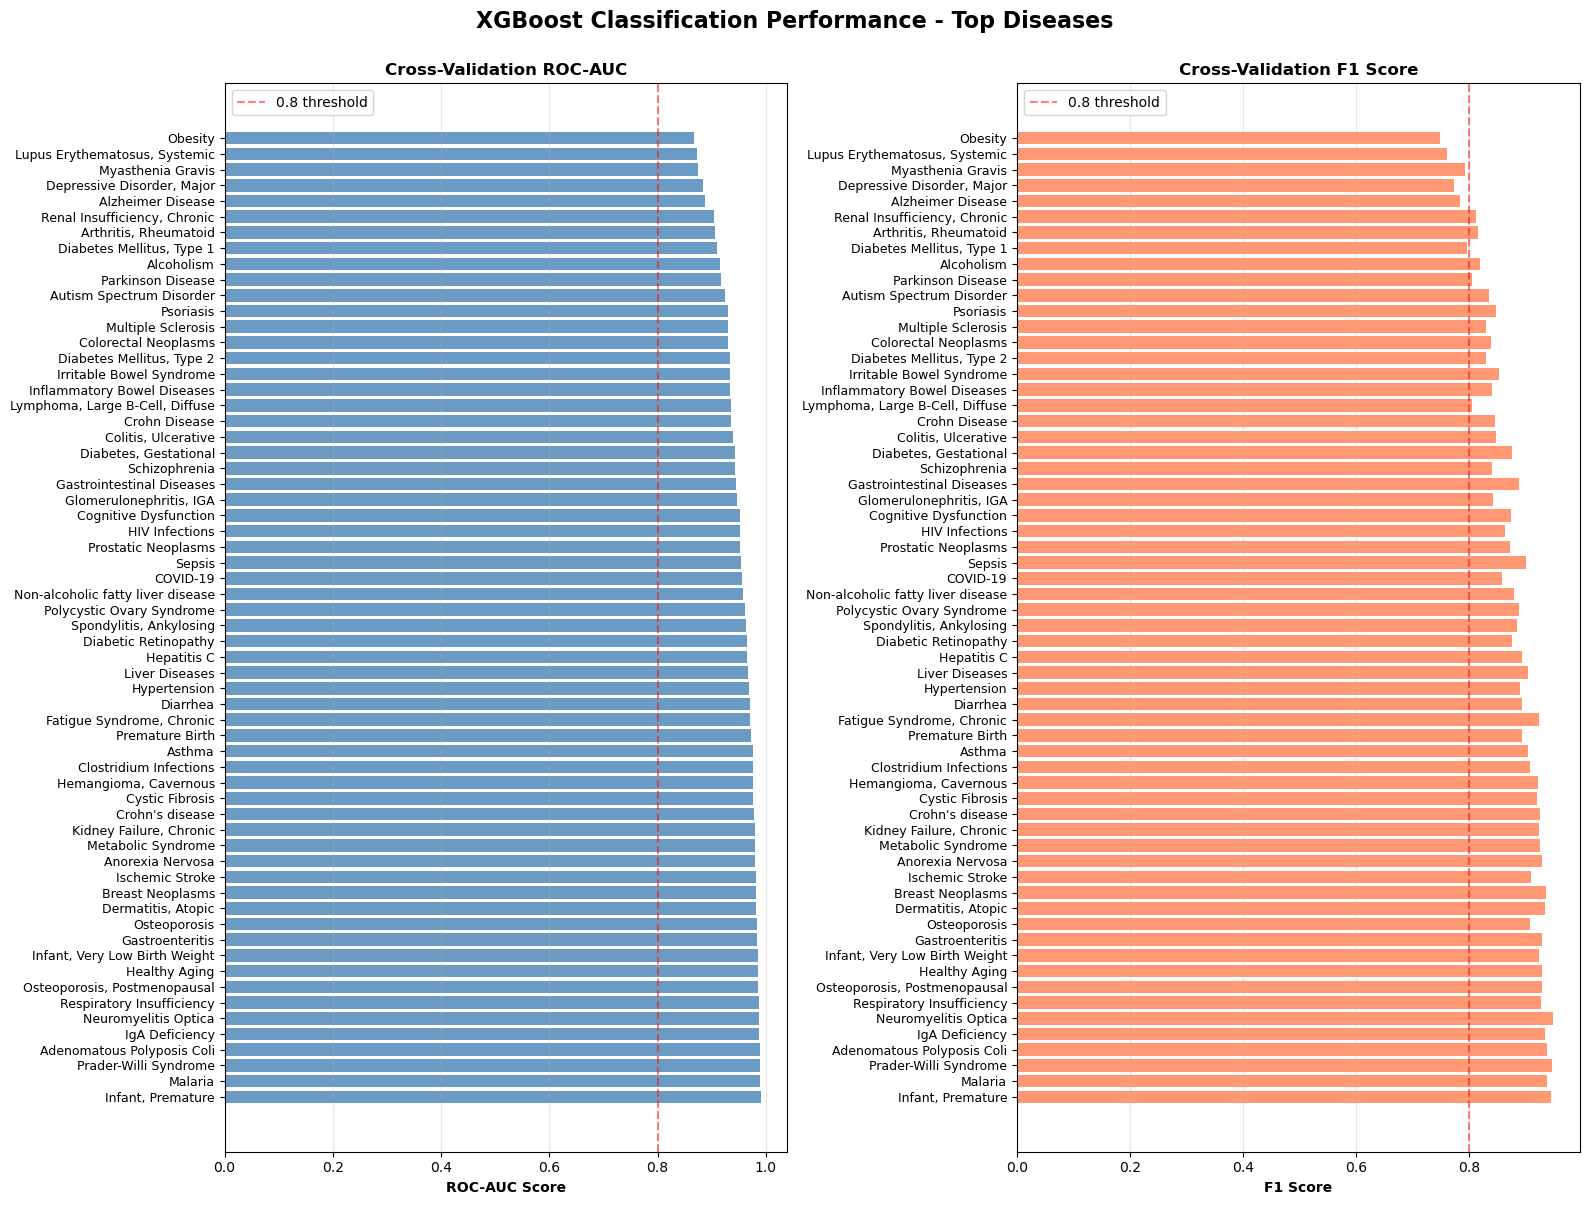

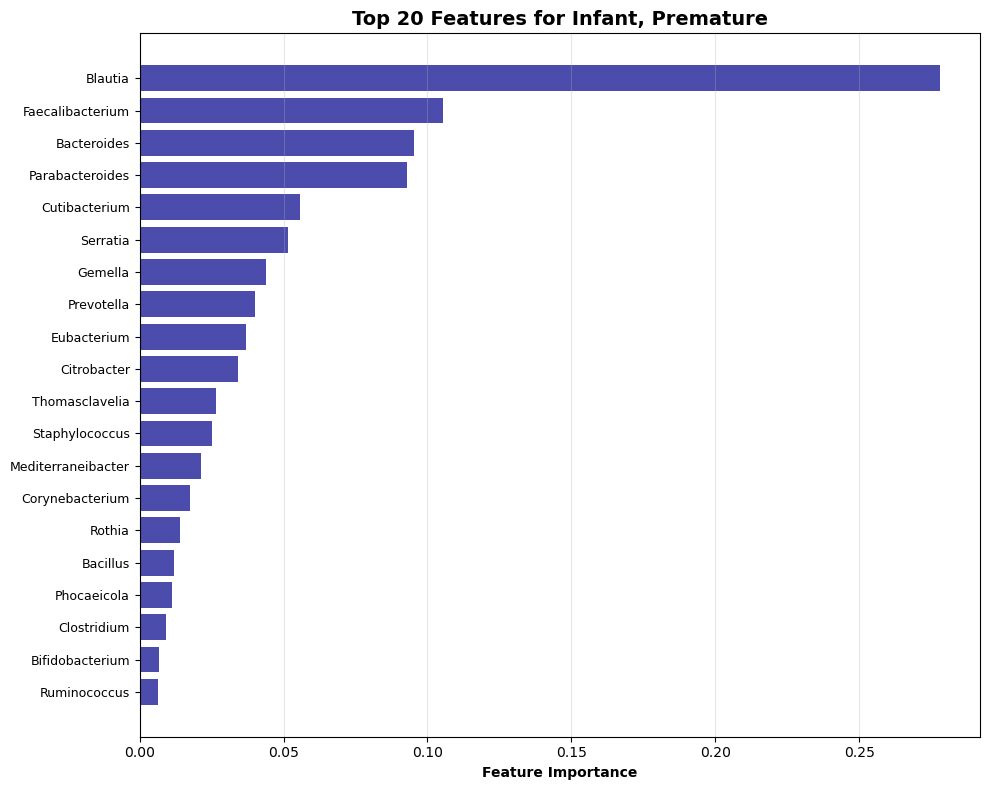

In [58]:
# ============================================================================
# 8. RESULTS ANALYSIS
# ============================================================================
print("\n[8/8] Analyzing results...")

results_df = pd.DataFrame(all_results)

# Debug: Show what columns we actually have
print(f"Available columns in results_df: {list(results_df.columns)}")

# Save results
results_df.to_csv('xgboost_classification_results.csv', index=False)
print("✓ Saved: xgboost_classification_results.csv")

# Filter for good models - adjust column names based on what exists
# First check which metric columns we have
roc_col = 'CV_ROC_AUC_Mean' if 'CV_ROC_AUC_Mean' in results_df.columns else 'Train_ROC_AUC'
f1_col = 'CV_F1_Mean' if 'CV_F1_Mean' in results_df.columns else 'Train_F1'

print(f"Using ROC column: {roc_col}")
print(f"Using F1 column: {f1_col}")

# Filter for good models (CV ROC-AUC > 0.80 and CV F1 > 0.70)
good_models = results_df[
    (results_df[roc_col] > 0.80) & 
    (results_df[f1_col] > 0.70)
].copy()

print(f"\n✓ Found {len(good_models)} diseases with good classification performance")

if len(good_models) > 0:
    # Sort by ROC-AUC
    good_models = good_models.sort_values(roc_col, ascending=False)
    
    # Determine which columns to display based on what's available
    available_cols = results_df.columns.tolist()
    display_cols = ['Disease', roc_col, f1_col]
    
    # Add precision and recall if available
    precision_col = 'CV_Precision_Mean' if 'CV_Precision_Mean' in available_cols else 'Train_Precision'
    recall_col = 'CV_Recall_Mean' if 'CV_Recall_Mean' in available_cols else 'Train_Recall'
    
    if precision_col in available_cols:
        display_cols.append(precision_col)
    if recall_col in available_cols:
        display_cols.append(recall_col)
    
    # Display top results
    print("\nTop 10 Best Classified Diseases:")
    print("="*80)
    print(good_models[display_cols].head(10).to_string(index=False))
    
    # ========================================================================
    # Visualization: Performance metrics
    # ========================================================================
    top_n = min(62, len(good_models))
    top_models = good_models.head(top_n)
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 12))
    
    # ROC-AUC
    axes[0].barh(range(len(top_models)), top_models[roc_col], 
                 xerr=top_models[f'{roc_col.replace("_Mean", "_Std")}'] if f'{roc_col.replace("_Mean", "_Std")}' in top_models.columns else None, 
                 color='steelblue', alpha=0.8)
    axes[0].set_yticks(range(len(top_models)))
    axes[0].set_yticklabels(top_models['Disease'], fontsize=9)
    axes[0].set_xlabel('ROC-AUC Score', fontweight='bold')
    axes[0].set_title('Cross-Validation ROC-AUC', fontweight='bold')
    axes[0].grid(axis='x', alpha=0.3)
    axes[0].axvline(0.8, color='red', linestyle='--', alpha=0.5, label='0.8 threshold')
    axes[0].legend()
    
    # F1 Score
    f1_std_col = f'{f1_col.replace("_Mean", "_Std")}' if f'{f1_col.replace("_Mean", "_Std")}' in top_models.columns else None
    axes[1].barh(range(len(top_models)), top_models[f1_col], 
                 xerr=f1_std_col, color='coral', alpha=0.8)
    axes[1].set_yticks(range(len(top_models)))
    axes[1].set_yticklabels(top_models['Disease'], fontsize=9)
    axes[1].set_xlabel('F1 Score', fontweight='bold')
    axes[1].set_title('Cross-Validation F1 Score', fontweight='bold')
    axes[1].grid(axis='x', alpha=0.3)
    axes[1].axvline(0.8, color='red', linestyle='--', alpha=0.5, label='0.8 threshold')
    axes[1].legend()
    
    plt.suptitle('XGBoost Classification Performance - Top Diseases', 
                 fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.savefig('classification_performance_summary.png', dpi=300, bbox_inches='tight')
    print("✓ Saved: classification_performance_summary.png")
    
    # ========================================================================
    # Feature importance for top disease
    # ========================================================================
    if len(good_models) > 0:
        top_disease = good_models.iloc[0]['Disease']
        
        # Check if feature importance exists for this disease
        if top_disease in feature_importance_dict and len(feature_importance_dict[top_disease]) > 0:
            top_features = feature_importance_dict[top_disease].head(20)
            
            plt.figure(figsize=(10, 8))
            plt.barh(range(len(top_features)), top_features['importance'], color='darkblue', alpha=0.7)
            plt.yticks(range(len(top_features)), top_features['feature'], fontsize=9)
            plt.xlabel('Feature Importance', fontweight='bold')
            plt.title(f'Top 20 Features for {top_disease}', fontweight='bold', fontsize=14)
            plt.gca().invert_yaxis()
            plt.grid(axis='x', alpha=0.3)
            plt.tight_layout()
            
            safe_name = top_disease.replace("/", "_").replace(" ", "_")
            plt.savefig(f'feature_importance_{safe_name}.png', dpi=300, bbox_inches='tight')
            print(f"✓ Saved: feature importance plot for {top_disease}")
        else:
            print(f"⚠ No feature importance data available for {top_disease}")
    
    # ========================================================================
    # Additional summary statistics
    # ========================================================================
    print("\n" + "="*80)
    print("PERFORMANCE SUMMARY")
    print("="*80)
    print(f"Total diseases analyzed: {len(results_df)}")
    print(f"Diseases with ROC-AUC > 0.80: {len(results_df[results_df[roc_col] > 0.80])}")
    print(f"Diseases with F1 > 0.70: {len(results_df[results_df[f1_col] > 0.70])}")
    print(f"Diseases with both ROC-AUC > 0.80 AND F1 > 0.70: {len(good_models)}")
    
    if len(good_models) > 0:
        print(f"\nBest performing disease: {good_models.iloc[0]['Disease']}")
        print(f"  ROC-AUC: {good_models.iloc[0][roc_col]:.4f}")
        print(f"  F1 Score: {good_models.iloc[0][f1_col]:.4f}")
        
    # Save the good models separately
    good_models.to_csv('good_classification_models.csv', index=False)
    print("\n✓ Saved: good_classification_models.csv")

else:
    print("\n⚠ No diseases met the performance criteria (ROC-AUC > 0.80 AND F1 > 0.70)")
    print("Consider relaxing the thresholds or checking the classification pipeline.")
    
    # Still save a summary
    print("\nSummary of all models:")
    print("="*80)
    summary_cols = ['Disease', roc_col, f1_col]
    if 'N_Disease' in results_df.columns:
        summary_cols.append('N_Disease')
    if 'N_Features' in results_df.columns:
        summary_cols.append('N_Features')
    
    print(results_df[summary_cols].sort_values(roc_col, ascending=False).to_string(index=False))

In [59]:
print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)
print("\nKey Files Generated:")
print("  1. xgboost_classification_results.csv - Complete results for all diseases")
print("  2. healthy_samples_pca_umap.png - Visualization of healthy cohort")
print("  3. [disease]_pca_umap.png - PCA/UMAP for each disease")
print("  4. classification_performance_summary.png - Performance metrics overview")
print("  5. feature_importance_*.png - Top features for best disease")
print("\nSummary Statistics:")
print(f"  Total diseases analyzed: {len(results_df)}")
print(f"  Diseases with good performance (AUC>0.8, F1>0.7): {len(good_models)}")
if len(good_models) > 0:
    print(f"  Best disease: {good_models.iloc[0]['Disease']}")
    print(f"  Best ROC-AUC: {good_models.iloc[0]['CV_ROC_AUC_Mean']:.4f}")
    print(f"  Best F1: {good_models.iloc[0]['CV_F1_Mean']:.4f}")
print("="*80)


ANALYSIS COMPLETE!

Key Files Generated:
  1. xgboost_classification_results.csv - Complete results for all diseases
  2. healthy_samples_pca_umap.png - Visualization of healthy cohort
  3. [disease]_pca_umap.png - PCA/UMAP for each disease
  4. classification_performance_summary.png - Performance metrics overview
  5. feature_importance_*.png - Top features for best disease

Summary Statistics:
  Total diseases analyzed: 62
  Diseases with good performance (AUC>0.8, F1>0.7): 62
  Best disease: Infant, Premature
  Best ROC-AUC: 0.9906
  Best F1: 0.9449
